In [3]:
################################################################## GENERAL IDEA ###################################################################
###################################################################################################################################################
############################################################### 1. PRE PROCESSING #################################################################
###################################################################################################################################################
## Create a data frame from csv file, then create two data frames one for each Station types (start, end) for easier data handling. 
## Making sure data are sorted by datetimes, handling missing data (if any), getting rid of data we do not care about, converting certain columns 
## to certain data types if needed.
## Then, create intervals and calculate values for each interval, handle upper/lower interval problems, and finally creating the final time_serie, 
## handling missing values if necessary. 
## All of the above are being conducted inside a function wich returns the final time series. 
## I did this because I wanted to easily create different time series using different intervals for testing purposes.
## At the end of pre processing, we devide the time series into training and testing data. This is also being conducted in a function because
## I wanted to easily create different training/testing data analogies for testing purposes.
###################################################################################################################################################
###################################################################################################################################################
########################################################## 2. ANALYSING THE TIME SERIES ###########################################################
###################################################################################################################################################
## Using ACF, PACF plot to get a better understanding of the time series.
## Performing ADF test to ensure/reject stationarity.
## Decompose the time series to better analyze it.
###################################################################################################################################################
###################################################################################################################################################
################################################################ 3. MODEL TESTING #################################################################
###################################################################################################################################################
## Having got as much information as I can from the analysis, I begin to try different models.
## If I find seasonality in the previous step then model that deal with seasonality must be used.
## If infomation from the analysis are not clear, then more and different kind of models should be tested.
###################################################################################################################################################
###################################################################################################################################################
######################################################### 4. RECREATING THE TIME SERIES ###########################################################
###################################################################################################################################################
## Recreating the time series to perform the analysis and model fitting on, with different intervals.
## Perform all the above steps in the new time series, only that this time we have a better understanding of our data, and can perform 
## more directed tests.
################################################################################################################################################### 

## **PREPROCESSING OF DATA**

In [4]:
######################### Time series creating function, using a file name and an integer representing the interval in hours ###########################

# Importing pandas library
import pandas as pd

def csvDataToTimeSerie(fileName, timeInterInHours):  
    # Creating a pandas data frame with the raw data of the csv file
    raw_df = pd.read_csv(fileName)

    # Creating separate data frames for start and end stations
    
    raw_start_df = raw_df[['TripId', 'StartTime', 'StartStationId']]
    raw_end_df = raw_df[['TripId', 'EndTime', 'EndStationId']]
    
    # Making sure the data we are going to work on are sorted by timestamp
    
    raw_start_sorted_df = raw_start_df.sort_values(by='StartTime')
    raw_end_sorted_df = raw_end_df.sort_values(by='EndTime')
    
    # Keeping only data that we want in each data frame (deleting entries where station id is not equal to 1)
    # Also resetting the data frames' indexes for better visualization-manipulation of data
    
    condition = raw_start_sorted_df['StartStationId'] == 1
    raw_start_sorted_df = raw_start_sorted_df[condition]
    raw_start_sorted_df = raw_start_sorted_df.reset_index(drop='True')
    
    condition = raw_end_sorted_df['EndStationId'] == 1
    raw_end_sorted_df = raw_end_sorted_df[condition]
    raw_end_sorted_df = raw_end_sorted_df.reset_index(drop='True')
    
    # Checking if there are NaN values in the the raw data frames
    
    start_df_nan_check = raw_start_sorted_df.isna().any()
    end_df_nan_check = raw_end_sorted_df.isna().any()
    # In this project there are non. If there where, we would have to decide how to deal with the empty spots
    
    # Converting Time columns to timestamps so that certain functions can be used on them
    
    raw_start_sorted_df['StartTime'] = pd.to_datetime(raw_start_sorted_df['StartTime'])
    raw_end_sorted_df['EndTime'] = pd.to_datetime(raw_end_sorted_df['EndTime'])

    # Defining the start and end timestamps of the time series
    # First we compare the min and max timestamps from the two data frames
    # and we keep the overall min and max timestamps
    
    start_time_1 = raw_start_sorted_df['StartTime'].min()
    start_time_2 = raw_end_sorted_df['EndTime'].min()
    if (start_time_1 > start_time_2):
        start_time = start_time_2
    else:
        start_time = start_time_1
    
    end_time_1 = raw_start_sorted_df['StartTime'].max()
    end_time_2 = raw_end_sorted_df['EndTime'].max()
    if (end_time_1 > end_time_2):
        end_time = end_time_1
    else:
        end_time = end_time_2
    
    # Then we round the starting and ending hour (to the floor and ceiling hours respectively)
    
    start_time = start_time.floor('h')
    end_time = end_time.ceil('h')
    
    # This if will take action only if the timeInterInHours exactly devides 24 (total hours per day)
    # Not necessary but if the above is the case, then intervals deviding the total period will not split between different days
    
    if 24 % timeInterInHours == 0:
        start_mod = start_time.hour % timeInterInHours
        if start_mod != 0:
            start_time -= pd.Timedelta(hours=start_mod)
        
        end_mod = end_time.hour % timeInterInHours
        if end_mod != 0:
            end_time += pd.Timedelta(hours=end_mod)
    
    # Creating the final timestamp values of the time series using a frequency of timeInterInHours hours
    # and inserting it into a pandas data frame
    # Each timestamp of the time_serie will indicate the demand for the time period [current_timestamp, current_timestamp+Xhours)
    
    interval = str(timeInterInHours) + 'h'
    timestamps = pd.date_range(start=start_time, end=end_time, freq=interval)
    
    # There is a change that the max timestamp created is less than the end_time of our data.
    # If this is the case we add one more interval, so that we will not miss any data when creating the time serie
    
    if (timestamps[-1] < end_time):
        extra_timestamp = timestamps[-1] + pd.Timedelta(hours=timeInterInHours)
        timestamps = timestamps.append(pd.DatetimeIndex([extra_timestamp]))
    
    # Creating the total period for the time serie
    
    pre_time_serie = pd.DataFrame({'Time': timestamps})
    
    # Calculating the bicycles taken and returned in each period,
    # and then calculating the demand in ech period by subtracting the above
    
    pre_time_serie['Taken'] = 0
    pre_time_serie['Returned'] = 0
    
    # Inserting the taken bicycle values
    i = 0
    max_i = raw_start_sorted_df.index.max()
    max_index = pre_time_serie.index.max()
    for index in range(0, max_index):
        count = 0
        cur_time = raw_start_sorted_df.loc[i, 'StartTime']
        low_time = pre_time_serie.loc[index, 'Time']
        high_time = pre_time_serie.loc[index+1, 'Time']
        while (cur_time>=low_time and cur_time<high_time):
            count += 1
            i += 1
            if (i>max_i): break
            cur_time = raw_start_sorted_df.loc[i, 'StartTime']
        pre_time_serie.loc[index, 'Taken'] = count
        if (i>max_i): break
    
    # Inserting the returned bicycle values
    i = 0
    max_i = raw_end_sorted_df.index.max()
    for index in range(0, max_index):
        count = 0
        cur_time = raw_end_sorted_df.loc[i, 'EndTime']
        low_time = pre_time_serie.loc[index, 'Time']
        high_time = pre_time_serie.loc[index+1, 'Time']
        while (cur_time>=low_time and cur_time<high_time):
            count += 1
            i += 1
            if (i>max_i): break
            cur_time = raw_end_sorted_df.loc[i, 'EndTime']
        pre_time_serie.loc[index, 'Returned'] = count
        if (i>max_i): break
    
    # Creating the resulting time serie by deleted columns that are not needed,
    # deleting the last row, which does not represent a period we want
    # and make the timestamps' column the index
    # We do not have to handle missing values etc,
    # because as we can see from the raw data set, data is spread in any kind day/hour
    
    # If we had to deal with missing values, then usually one of three methods is chosen:
    # 1. Fill with front interval's value with time_serie.Demand.fillna(method = 'bfill') a.k.a "back filling"
    # 2. Fill with back interval's value with time_serie.Demand.fillna(method = 'ffill') a.k.a "front filling"
    # 3. Fill with the mean of all time_serie data with time_serie.Demand.fillna(value = time_serie.Demand.mean()) -- NOT good choice for time series
    #    because usually we observe a periodicity in data and data are strongly connected with neighbor data
    
    pre_time_serie['Demand'] = pre_time_serie['Returned'] - pre_time_serie['Taken']
    time_series = pre_time_serie.copy()
    time_series.drop(columns=['Returned'], inplace=True)
    time_series.drop(columns=['Taken'], inplace=True)
    time_series.drop(time_series.index[-1], inplace=True)
    time_series.set_index('Time', inplace=True)

    freq = str(timeInterInHours) + "h"
    time_series = time_series.asfreq(freq)
    return time_series

############################################ Function to split the time series into training and testing data #######################################

def timeSerieSplit(time_serie, training_perc, testing_perc):
    size = int(len(time_serie)*training_perc)
    training_data = time_serie.iloc[:size]
    testing_data = time_serie.iloc[size:]
    return training_data, testing_data

**TIME SERIES CREATION**

In [5]:
### Creating a time series from the data.csv file's data, with a 2 hour interval and splitting into 70% training, 30% testing data ###

time_serie = csvDataToTimeSerie('data.csv', 2)
ts, ts_test = timeSerieSplit(time_serie, 0.7, 0.3)

## **TIME SERIES ANALYSIS START**

**COMPARING OUR TIME SERIES WITH WHITE NOISE**

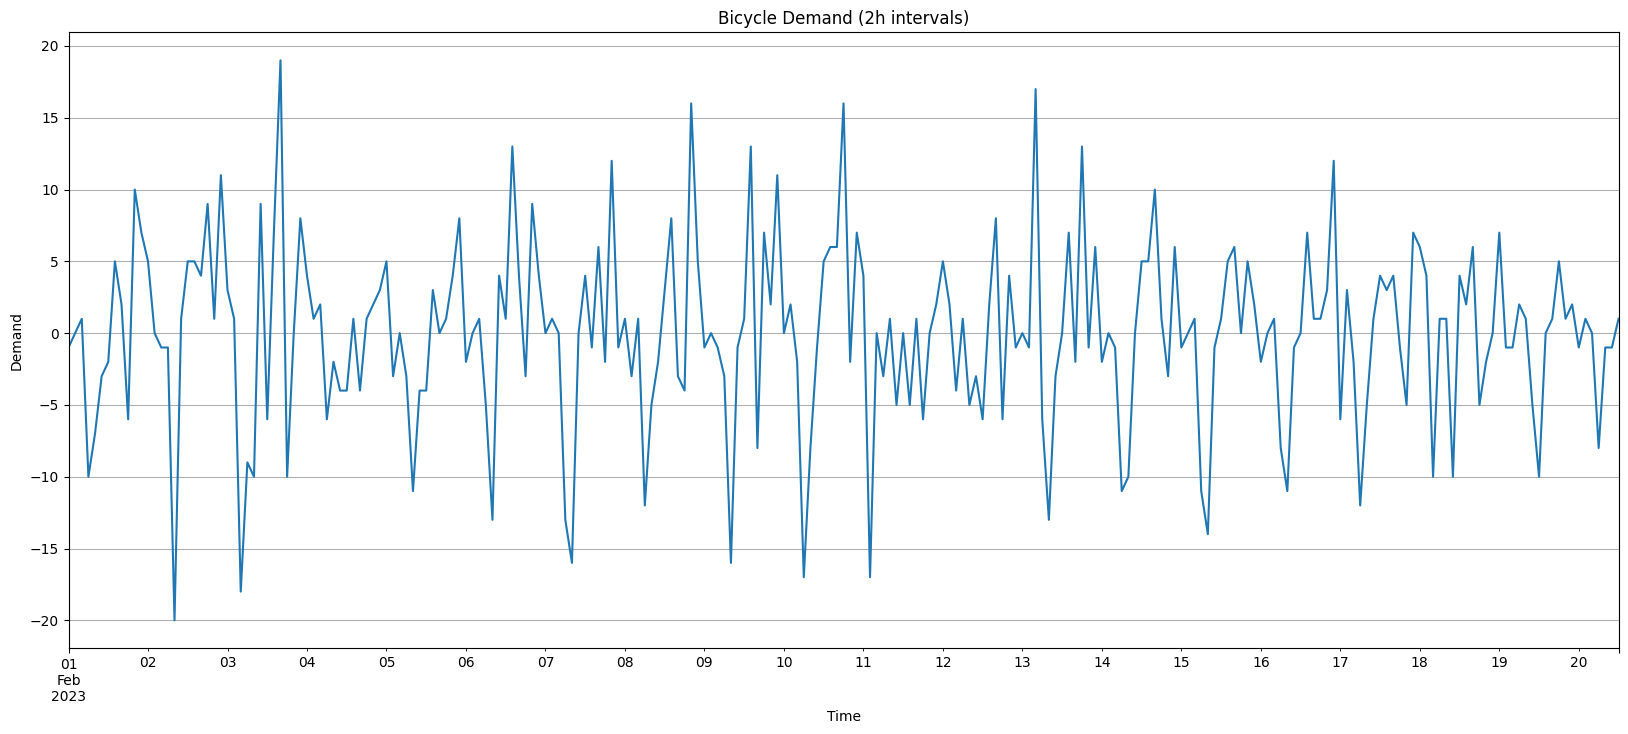

C:\Users\panag\AppData\Local\Temp\ipykernel_6164\2614947147.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts.loc[:,'white_noise'] = white_noise


                     Demand  white_noise
Time                                    
2023-02-01 00:00:00      -1     4.238594
2023-02-01 02:00:00       0    -4.848880
2023-02-01 04:00:00       1    12.859626
2023-02-01 06:00:00     -10     1.287009
2023-02-01 08:00:00      -7     1.710178
...                     ...          ...
2023-02-20 04:00:00       0    -6.489422
2023-02-20 06:00:00      -8    -4.575259
2023-02-20 08:00:00      -1    10.651636
2023-02-20 10:00:00      -1    -4.397889
2023-02-20 12:00:00       1     1.433744

[235 rows x 2 columns]


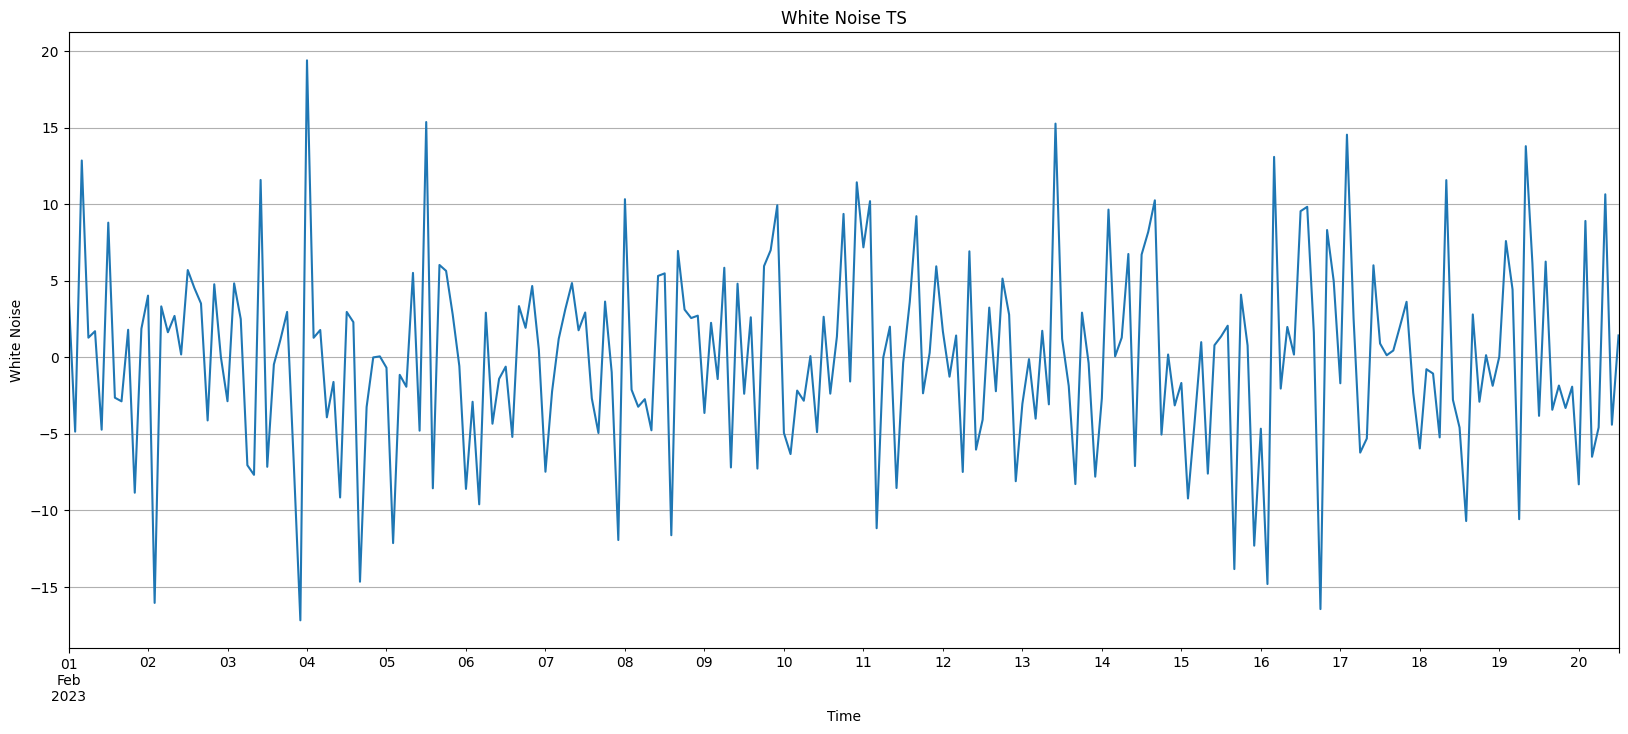

In [6]:
# Plotting the time serie through the data frame

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

ts.Demand.plot(figsize = (20, 8))
plt.title("Bicycle Demand (2h intervals)")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.grid()
plt.savefig('./images/ts_2h_intervals.png')
plt.show()

# White noise plot, following a normal distribution with mean and std derived from the time series data
white_noise = np.random.normal(loc = ts.Demand.mean(), scale = ts.Demand.std(), size = len(ts))
ts.loc[:,'white_noise'] = white_noise
print(ts)
ts.white_noise.plot(figsize = (20, 8))
plt.title('White Noise TS')
plt.xlabel('Time')
plt.ylabel('White Noise')
plt.grid()
plt.show()

We can see that the bicycle demand time series plot looks a lot like the white noise time series plot.<br>
They surely both do not have any trend, having a mean very close to zero. The std also seems to be constant.<br>
Regarding to seasonality, in white noise we are sure that there is non there. But in bicycle demand, we see that there could or not exist some daily seasonality. There seems to be some kind of periodicity there, but it does not seem strong. 

**FINDING TREND**

It is obvious by the previous graph that no trend exists in the time series

**FINDING SEASONALITY**

From the above graph it seems that there could exist seasonality of 1 day period.
We will check this hypothesis using autocorrelation.
We can also try to find if there is a correlation in every week's data (84 lags), 
    but with the limited data we have, this examination could lead us to misleading conclusions.

**CORRELATION TEST WITH ACF METHOD**

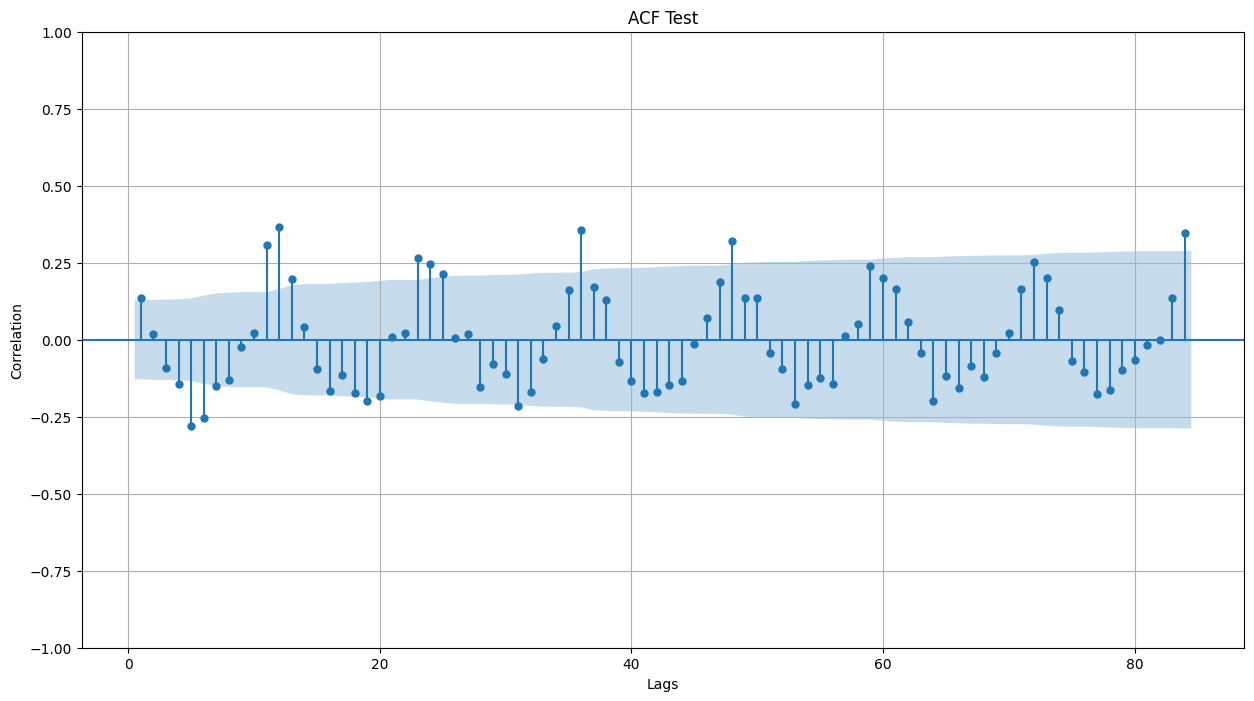

In [60]:
import statsmodels.graphics.tsaplots as sgt

sgt.plot_acf(ts.Demand, lags = 84, zero = False)
plt.title("ACF Test")
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.grid()
plt.rcParams["figure.figsize"] = (15, 8)
plt.savefig('./images/acf_for_ts.png')
plt.show()

Even though the ACF method does not give strong direct/indirect correlations between present and past values,
we can see a pattern in the graph with a frequency of 1 day (12 lags x 2 hour interval).
This indicates that MAYBE seasonality exists in the time series.

**CORRELATION TEST WITH PACF METHOD**

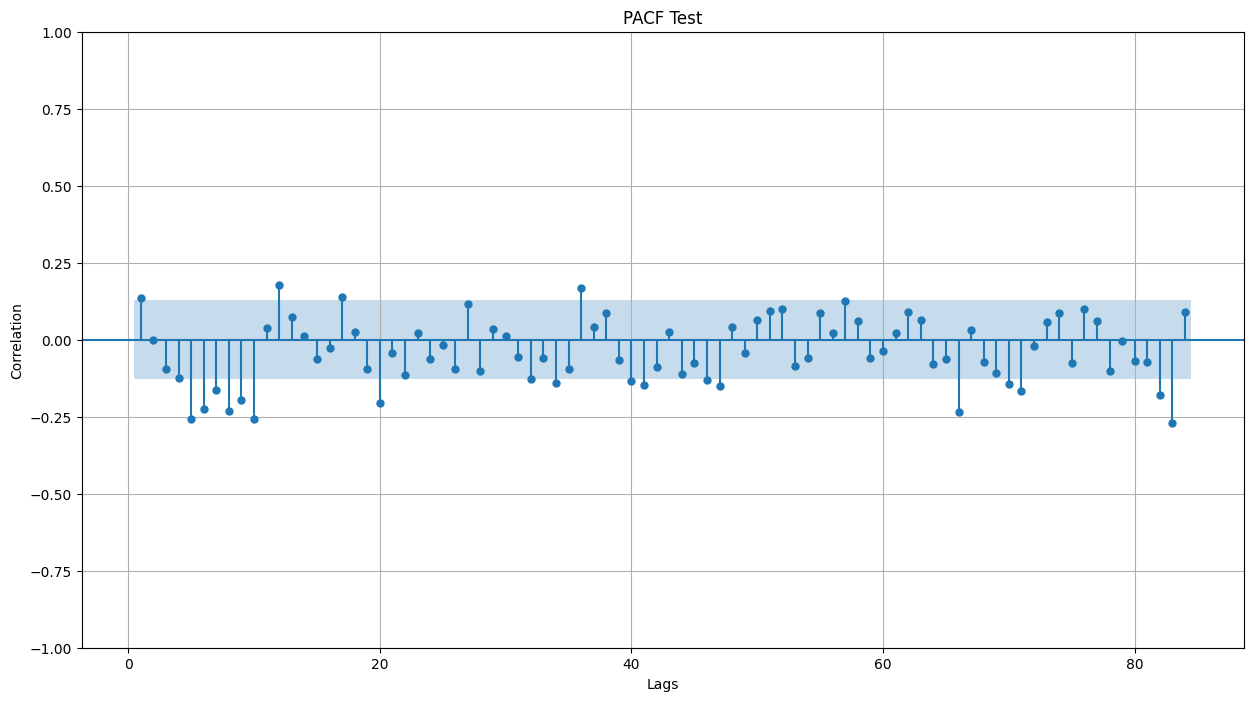

In [8]:
sgt.plot_pacf(ts.Demand, lags = 84, zero = False, method = 'ols')
plt.title("PACF Test")
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.grid()
plt.rcParams["figure.figsize"] = (15, 8)
plt.savefig('./images/pacf_for_ts.png')
plt.show()

With the use of PACF method we conclude that there is no significant direct correlation between timestamps of any lag size.
We could try though to use AR model with 5,6,8,9,10,12,66,83 lags maybe, because we see SOME correlation there.<br>
Though direct correlation with 66, 83 lags may be misleading, because we do not have a time series big enough to indicate such a thing with certainty
(our data consist of 235 observations).

**DECOMPOSING SEASONALITY** with the "naive" method

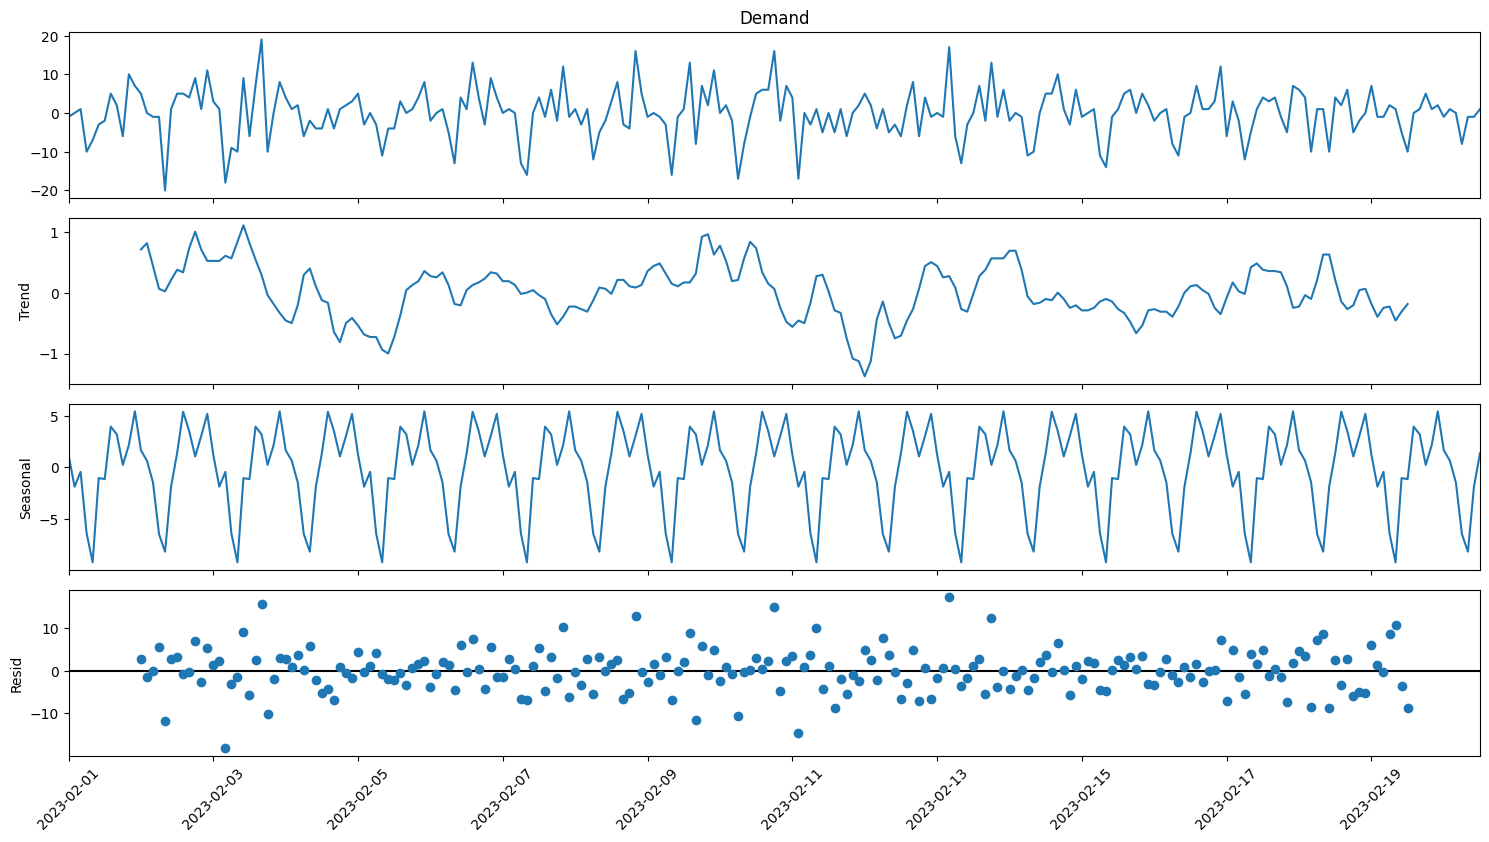

In [9]:
# We will use seasonal decomposition to split the seasonality from the time series

import statsmodels.tsa.seasonal as stse

s_dec_add = stse.seasonal_decompose(ts.Demand)
s_dec_add.plot()
plt.xticks(rotation = 45)
plt.show()

In [10]:
ts_seasonality = s_dec_add.seasonal
ts_seasonality = ts_seasonality.to_frame()
ts_seasonality = ts_seasonality.rename(columns={'seasonal': 'season_demand'})
ts_no_season = ts.copy()
ts_no_season['Demand'] = ts['Demand'] - ts_seasonality['season_demand']

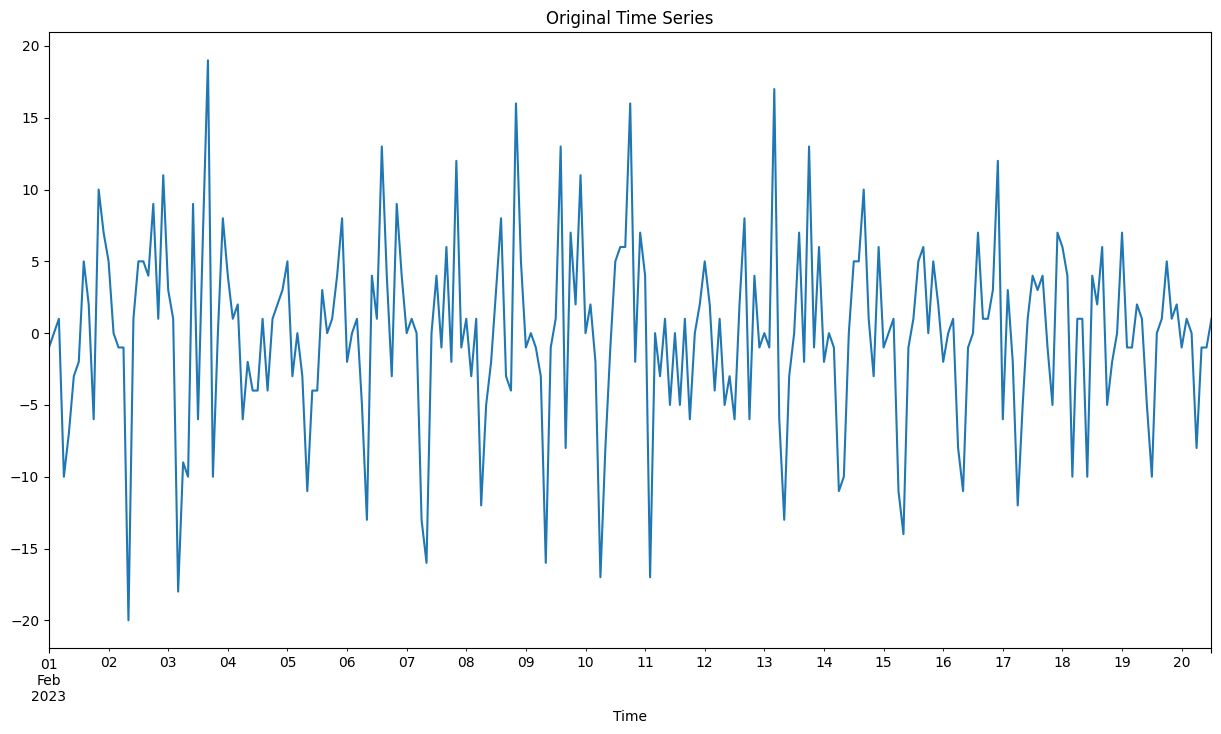

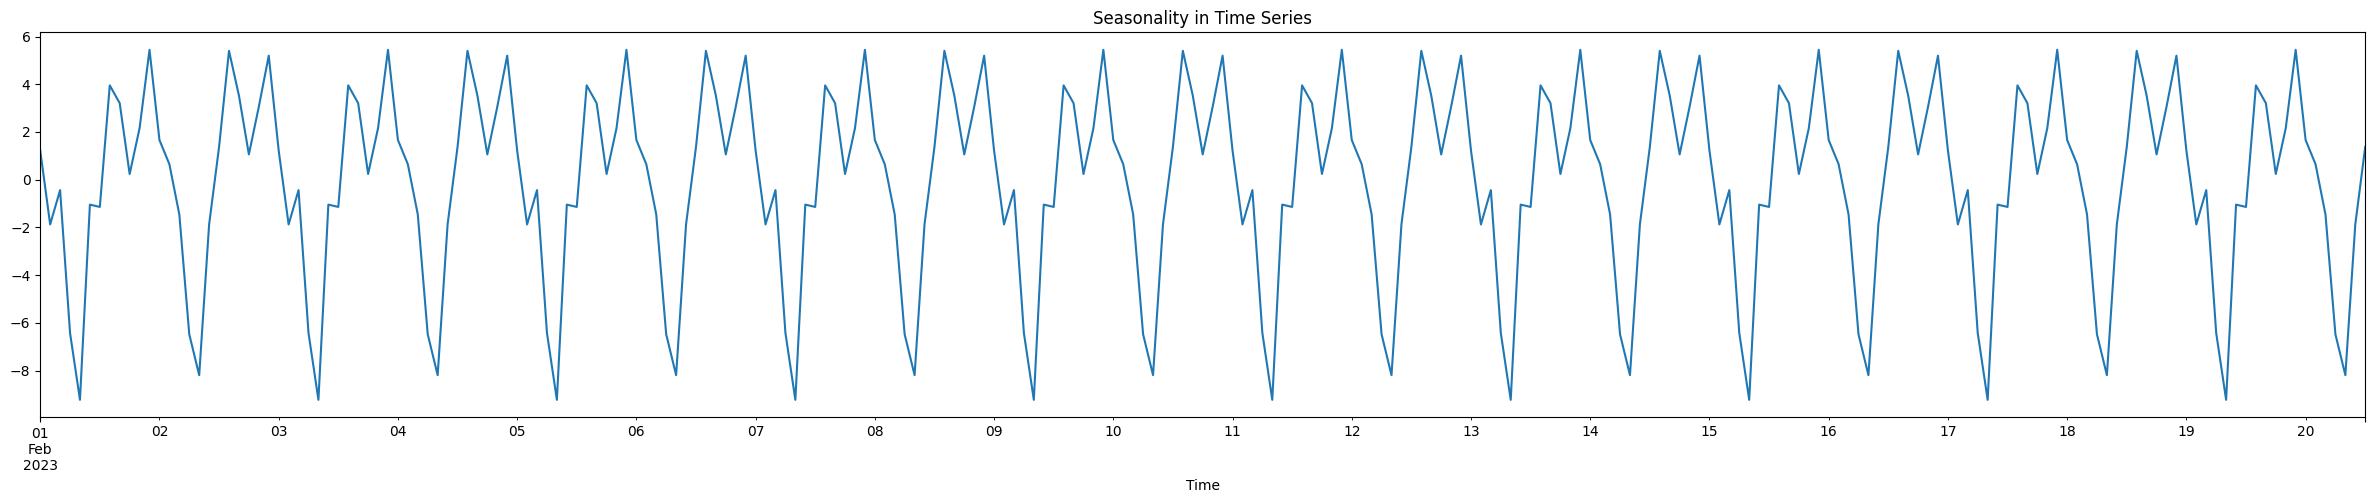

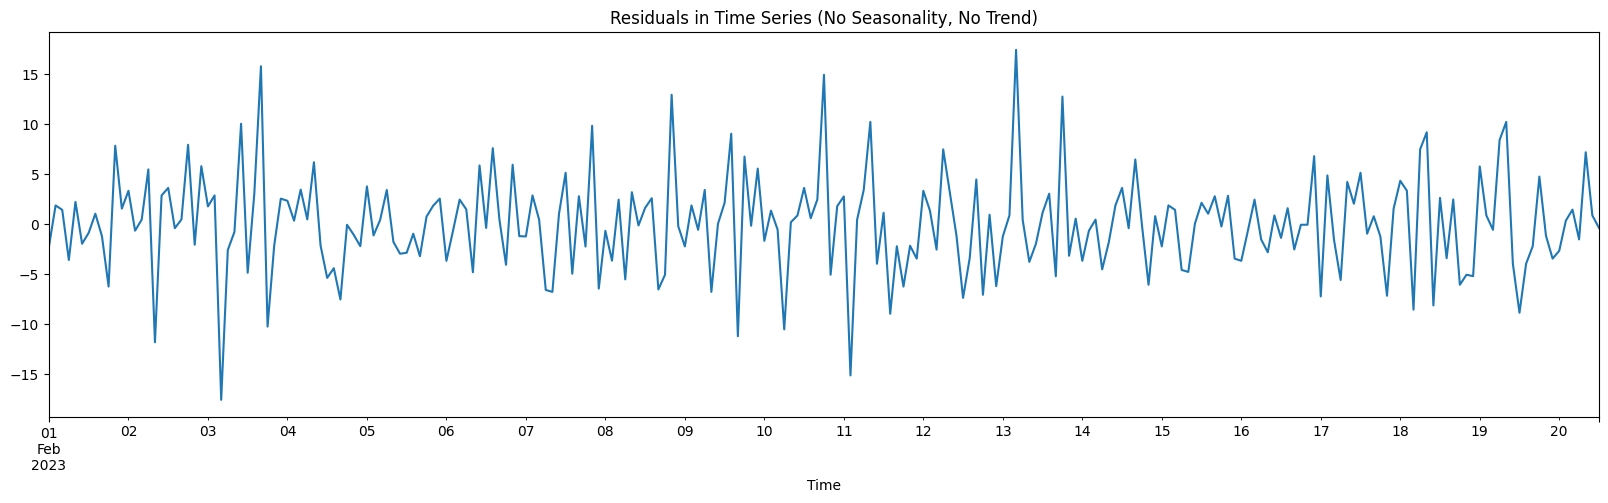

In [11]:
ts.Demand.plot()
plt.rcParams["figure.figsize"] = (30, 5)
plt.title("Original Time Series")
plt.show()
ts_seasonality.season_demand.plot()
plt.title("Seasonality in Time Series")
plt.rcParams["figure.figsize"] = (20, 5)
plt.show()
ts_no_season.Demand.plot()
plt.title("Residuals in Time Series (No Seasonality, No Trend)")
plt.rcParams["figure.figsize"] = (20, 5)
plt.show()

**ACF and PACF TEST for the time series desomposed from seasonality with "naive" method**

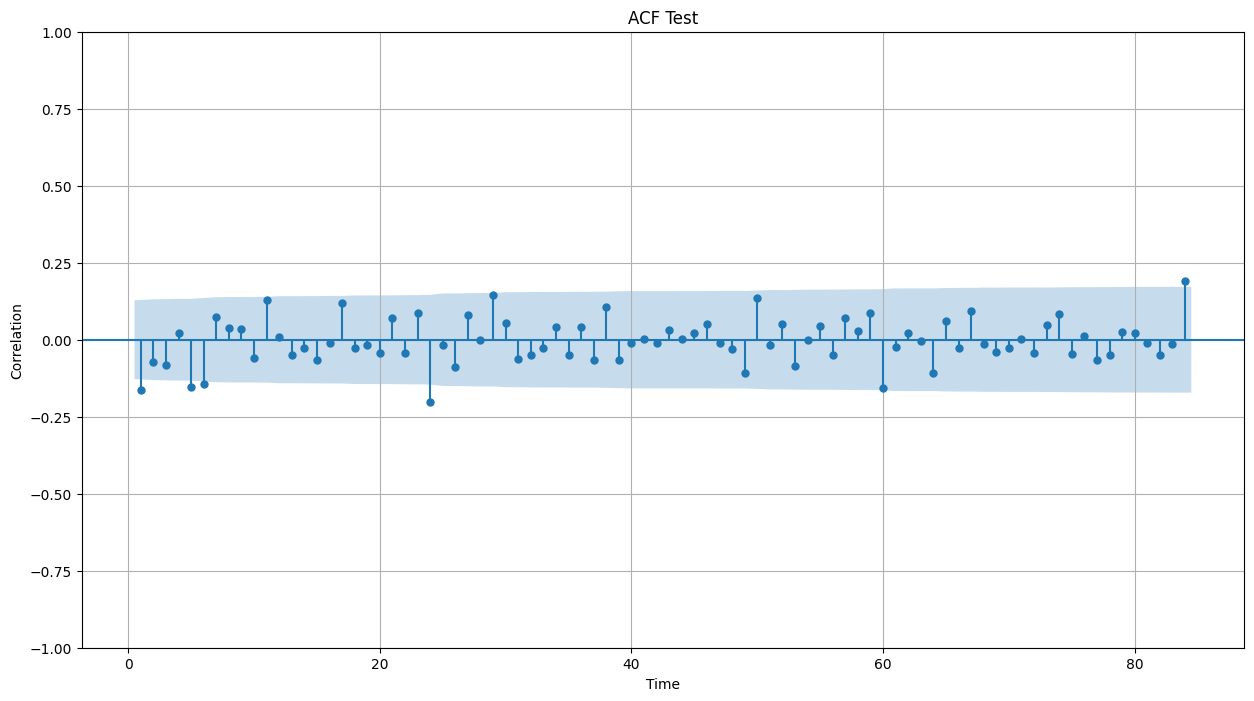

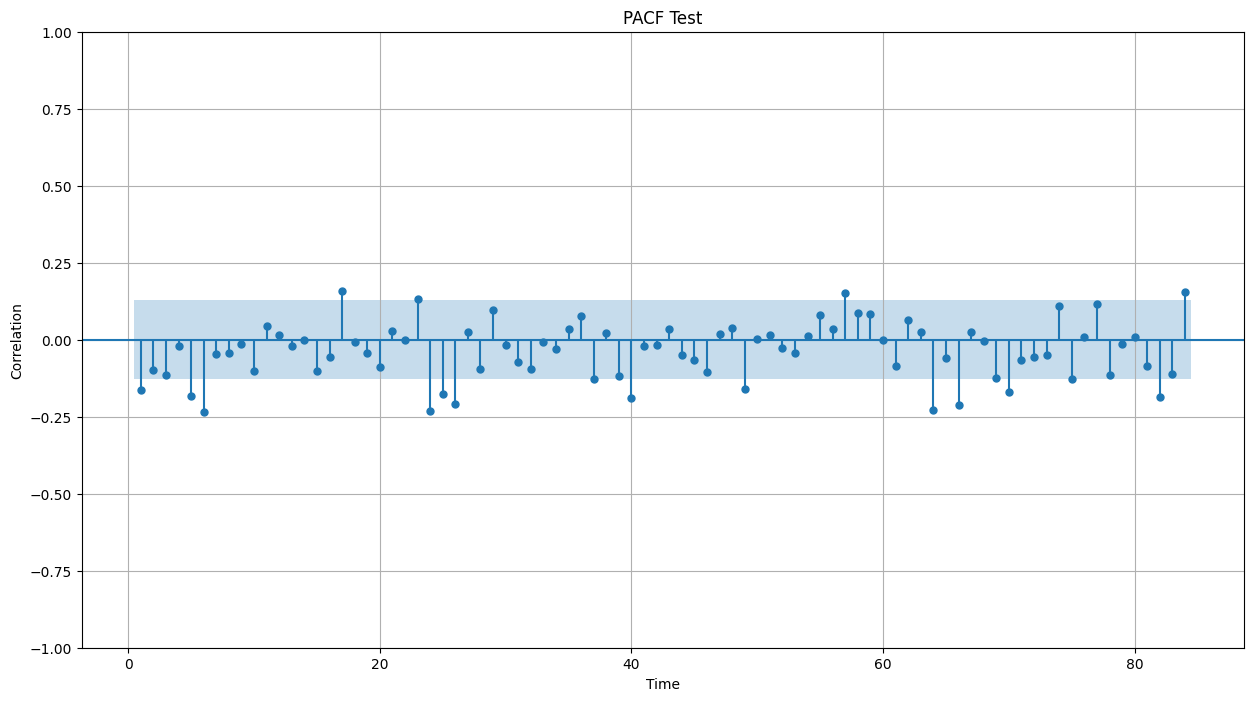

In [61]:
sgt.plot_acf(ts_no_season.Demand, lags = 84, zero = False)
plt.title("ACF Test")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.grid()
plt.rcParams["figure.figsize"] = (15, 8)
plt.show()

sgt.plot_pacf(ts_no_season.Demand, lags = 84, zero = False, method = 'ols')
plt.title("PACF Test")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.grid()
plt.rcParams["figure.figsize"] = (15, 8)
plt.show()

In the ACF method we can see that the previous periodicity no longer exist.<br>
Also, once again, neither in the ACF nor the PACF do we observe strong correlation between specific lagged timestamps.

**STATIONARITY TEST**

In [13]:
import statsmodels.tsa.stattools as sts

adf_ts = sts.adfuller(ts.Demand)
adf_ts_no_season = sts.adfuller(ts_no_season.Demand)

print("ADF Statistic for the ts: ", adf_ts[0])
print("p-value for the ts: ", adf_ts[1], "\n")

print("ADF Statistic for the ts decomposed from seasonal data (with naive method): ", adf_ts_no_season[0])
print("p-value for the ts decomposed from seasonal data (with naive method): ", adf_ts_no_season[1], "\n")

print("critical value (for 5%):", adf_ts[4]['5%'])

ADF Statistic for the ts:  -6.037258260877346
p-value for the ts:  1.3726001974839793e-07 

ADF Statistic for the ts decomposed from seasonal data (with naive method):  -9.925515423539762
p-value for the ts decomposed from seasonal data (with naive method):  2.9141158678486885e-17 

critical value (for 5%): -2.8745897386146817


We observe that the ADF_statistic < critical_value and that the possibility of the both ts and ts_no_season being non-stationary is close to 0.
It seems safe to declare that both are stationary.

Lets try to run the augmented dickey fuller test, without a max limit of 84 lags (1 week).

In [14]:
adf_ts_no_lag_limit = sts.adfuller(ts.Demand, maxlag=84)
adf_ts_no_season_no_lag_limit = sts.adfuller(ts_no_season.Demand, maxlag=84)

print("ADF Statistic for the ts: ", adf_ts_no_lag_limit[0])
print("p-value for the ts: ", adf_ts_no_lag_limit[1], "\n")

print("ADF Statistic for the ts decomposed from seasonal data (with naive method): ", adf_ts_no_season_no_lag_limit[0])
print("p-value for the ts decomposed from seasonal data (with naive method): ", adf_ts_no_season_no_lag_limit[1], "\n")

print("critical value (for 5%):", adf_ts_no_lag_limit[4]['5%'])

ADF Statistic for the ts:  -6.037258260877346
p-value for the ts:  1.3726001974839793e-07 

ADF Statistic for the ts decomposed from seasonal data (with naive method):  -4.034893994335627
p-value for the ts decomposed from seasonal data (with naive method):  0.001238423362773111 

critical value (for 5%): -2.8745897386146817


Observing the results, it appears as both series indeed are stationary.
 Also, considering the amount of data we have (235 observations), using more lags would decrease a lot the degrees of freedom in the test and the test could give very misleading results.

## **MODEL TEST START**

**AR MODEL TEST**

We are assuming that there is no seasonality in place, because AR model generally does not perform well with non-stationary data

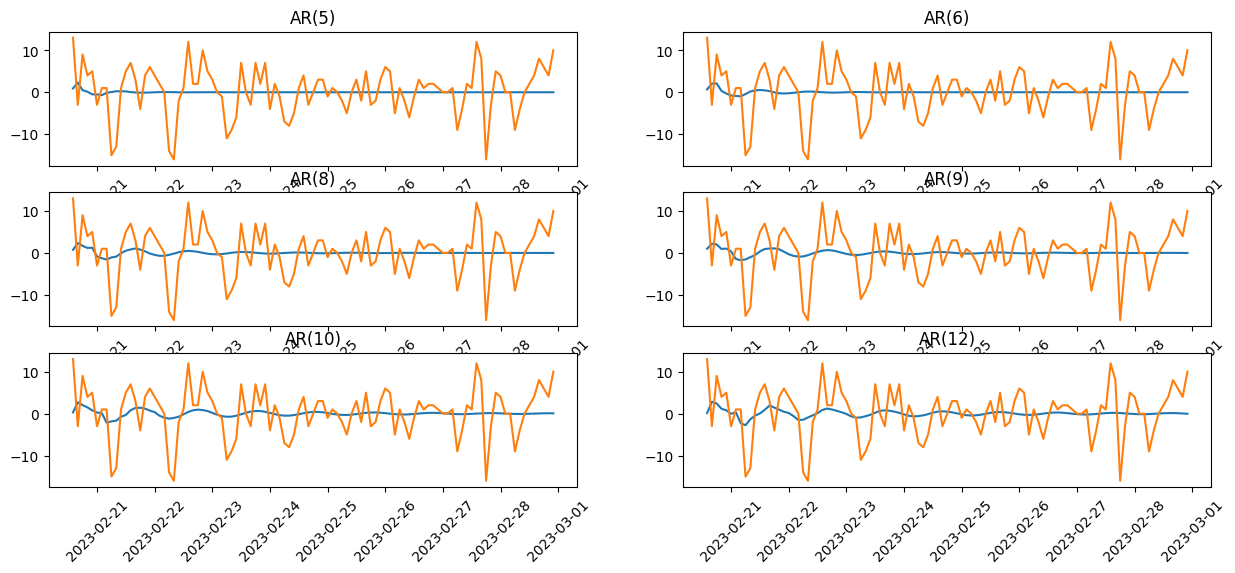

In [15]:
from statsmodels.tsa.ar_model import AutoReg

# As mentioned in previous tests, we will try using the Autoregressive model.
# We will try AR(5),AR(6),AR(8),AR(9),AR(10),AR(12),AR(66),AR(83)
# AR(66) and AR(83) will not be used because they most likely lead to overfitting

ts_model_ar5 = AutoReg(ts.Demand, lags=5).fit()
ts_model_ar6 = AutoReg(ts.Demand, lags=6).fit()
ts_model_ar8 = AutoReg(ts.Demand, lags=8).fit()
ts_model_ar9 = AutoReg(ts.Demand, lags=9).fit()
ts_model_ar10 = AutoReg(ts.Demand, lags=10).fit()
ts_model_ar12 = AutoReg(ts.Demand, lags=12).fit()

pred_ts_ar5 = ts_model_ar5.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
pred_ts_ar6 = ts_model_ar6.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
pred_ts_ar8 = ts_model_ar8.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
pred_ts_ar9 = ts_model_ar9.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
pred_ts_ar10 = ts_model_ar10.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
pred_ts_ar12 = ts_model_ar12.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)

plt.rcParams["figure.figsize"] = (15, 8)
plt.subplot(4, 2, 1)
plt.plot(pred_ts_ar5)
plt.plot(ts_test.Demand)
plt.xticks(rotation=45)
plt.title("AR(5)")

plt.subplot(4, 2, 2)
plt.plot(pred_ts_ar6)
plt.plot(ts_test.Demand)
plt.xticks(rotation=45)
plt.title("AR(6)")

plt.subplot(4, 2, 3)
plt.plot(pred_ts_ar8)
plt.plot(ts_test.Demand)
plt.xticks(rotation=45)
plt.title("AR(8)")

plt.subplot(4, 2, 4)
plt.plot(pred_ts_ar9)
plt.plot(ts_test.Demand)
plt.xticks(rotation=45)
plt.title("AR(9)")

plt.subplot(4, 2, 5)
plt.plot(pred_ts_ar10)
plt.plot(ts_test.Demand)
plt.xticks(rotation=45)
plt.title("AR(10)")

plt.subplot(4, 2, 6)
plt.plot(pred_ts_ar12)
plt.plot(ts_test.Demand)
plt.xticks(rotation=45)
plt.title("AR(12)")

plt.savefig('./images/ts_ar_models.png')
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import root_mean_squared_error as rmse
print('MAE')
print("AR(5):", round(mae(ts_test.Demand, pred_ts_ar5), 3))
print("AR(6):", round(mae(ts_test.Demand, pred_ts_ar6), 3))
print("AR(8):", round(mae(ts_test.Demand, pred_ts_ar8), 3))
print("AR(9):", round(mae(ts_test.Demand, pred_ts_ar9), 3))
print("AR(10):", round(mae(ts_test.Demand, pred_ts_ar10), 3))
print("AR(12):", round(mae(ts_test.Demand, pred_ts_ar12), 3), "\n")

print('RMSE')
print("AR(5)", round(rmse(ts_test.Demand, pred_ts_ar5), 3))
print("AR(6):", round(rmse(ts_test.Demand, pred_ts_ar6), 3))
print("AR(8):", round(rmse(ts_test.Demand, pred_ts_ar8), 3))
print("AR(9):", round(rmse(ts_test.Demand, pred_ts_ar9), 3))
print("AR(10):", round(rmse(ts_test.Demand, pred_ts_ar10), 3))
print("AR(12):", round(rmse(ts_test.Demand, pred_ts_ar12), 3))

MAE
AR(5): 4.352
AR(6): 4.337
AR(8): 4.304
AR(9): 4.271
AR(10): 4.179
AR(12): 4.187 

RMSE
AR(5) 5.809
AR(6): 5.783
AR(8): 5.701
AR(9): 5.625
AR(10): 5.535
AR(12): 5.521


Even though the AR model when using a lot of lags it appears to be following the test data a little better, as we can see
 from the calculated errors they are not the best choices.<br>
From the above results our best choices would be AR(10) and AR(12).

After some tests, I found that the AR(45) model is the one that gives the best prediction with minimum MAE, RMSE

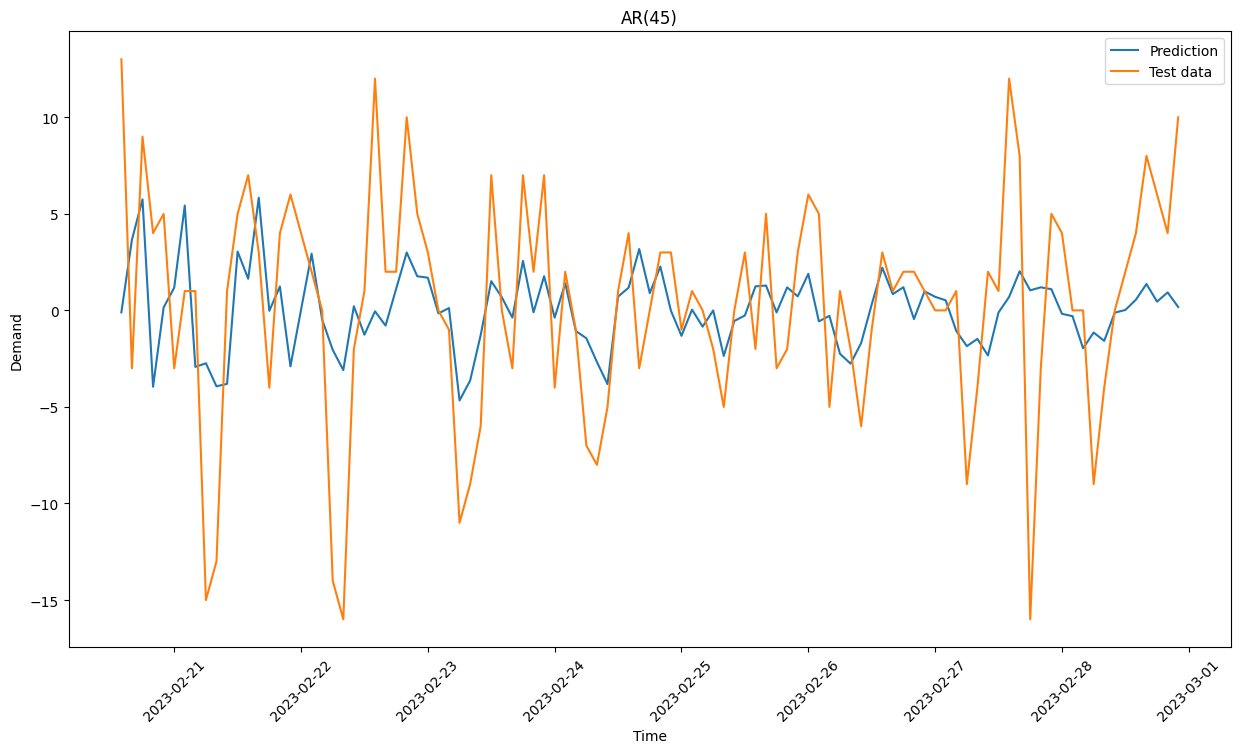

MAE AR(45): 3.892
RMSE AR(45) 5.135


In [62]:
ts_model_ar45 = AutoReg(ts.Demand, lags=45).fit()
pred_ts_ar45= ts_model_ar45.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
plt.plot(pred_ts_ar45, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.xticks(rotation=45)
plt.title("AR(45)")
plt.show()
print("MAE AR(45):", round(mae(ts_test.Demand, pred_ts_ar45), 3))
print("RMSE AR(45)", round(rmse(ts_test.Demand, pred_ts_ar45), 3))

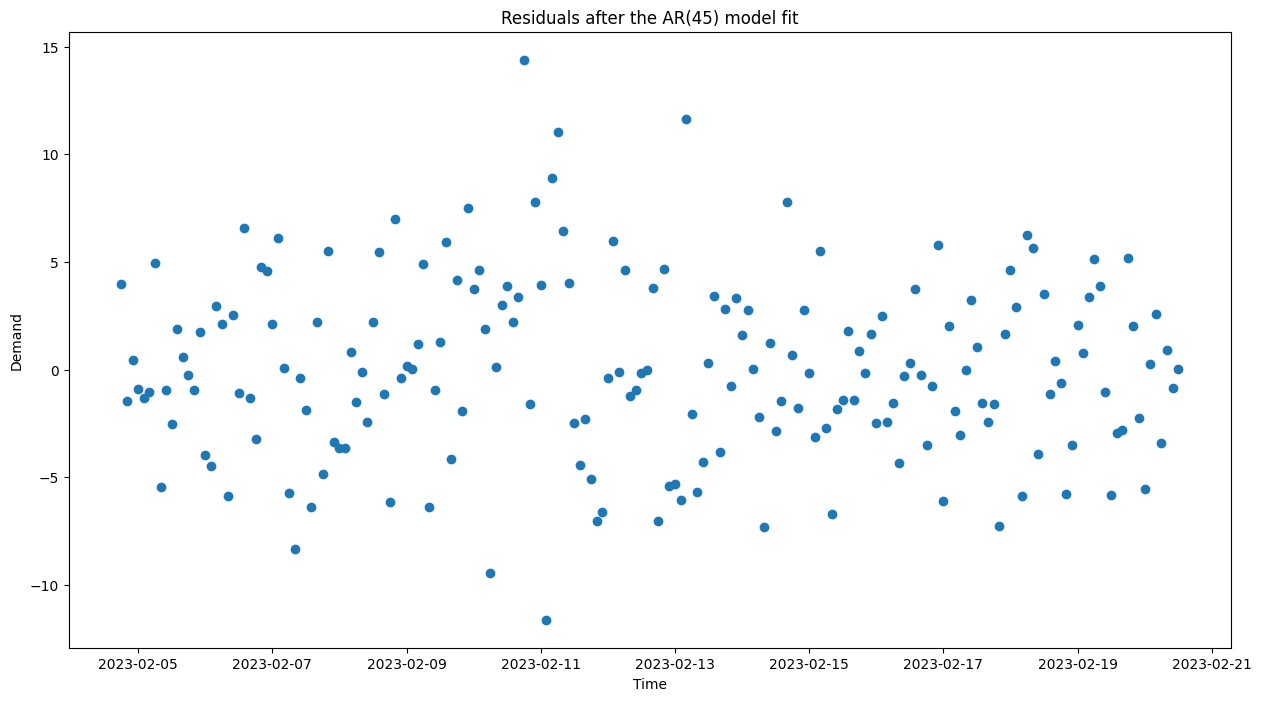

Residuals mean:  -0.0
Residuals variance:  17.303


In [18]:
# Checking the residuals/error term for the AR(45) model we created
plt.plot(ts_model_ar45.resid, 'o')
plt.title("Residuals after the AR(45) model fit")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.savefig('./images/ts_ar45_residuals.png')
plt.show()
print("Residuals mean: ", round(ts_model_ar45.resid.mean(), 3))
print("Residuals variance: ", round(ts_model_ar45.resid.var(), 3))

We can see that the residuls do have a mean of almost zero, but they are not gathered around zero. They are scattered all
over the place. This is a strong indication that the AR(45) model is performing poorly.
Also, we must have in mind that the more lags we add, the more chance there is for overfitting, and the more we are fitting our model to our specific data.  

**ARMA MODEL TEST**

We are assuming that there is no seasonality in place, because AR model generally does not perform well with non-stationary data

Again we take a look at the ACF and PACF tests for our time series

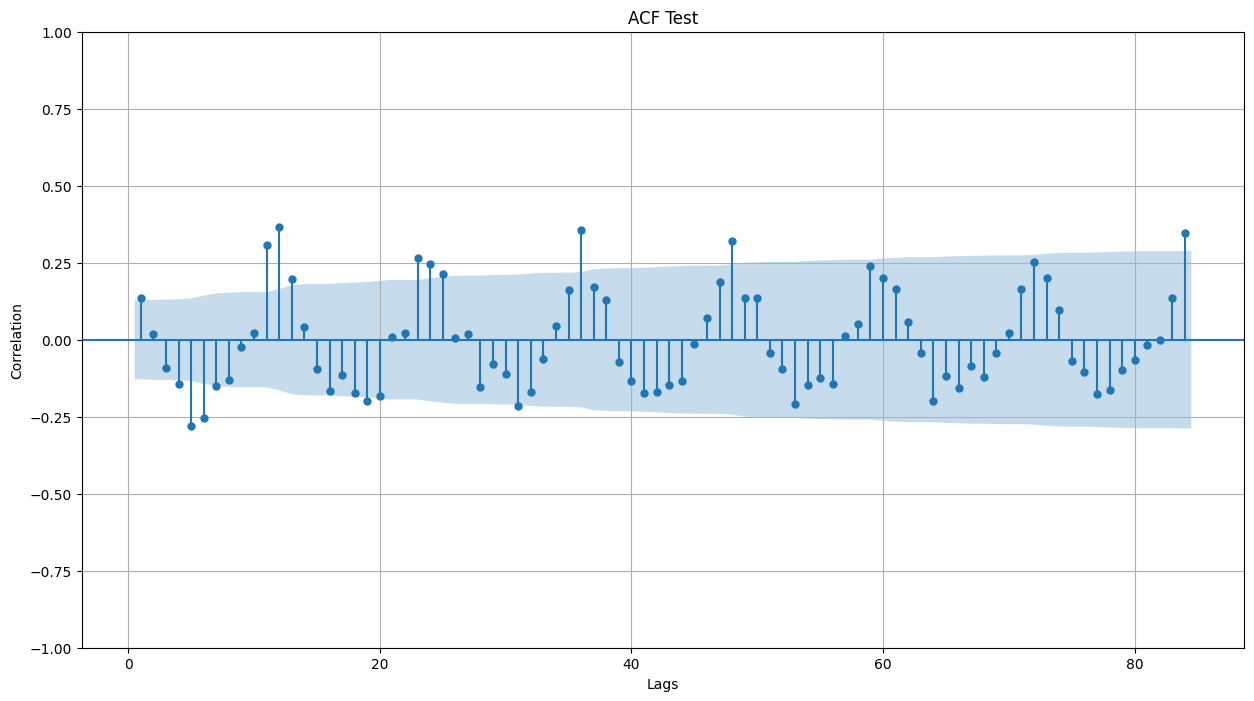

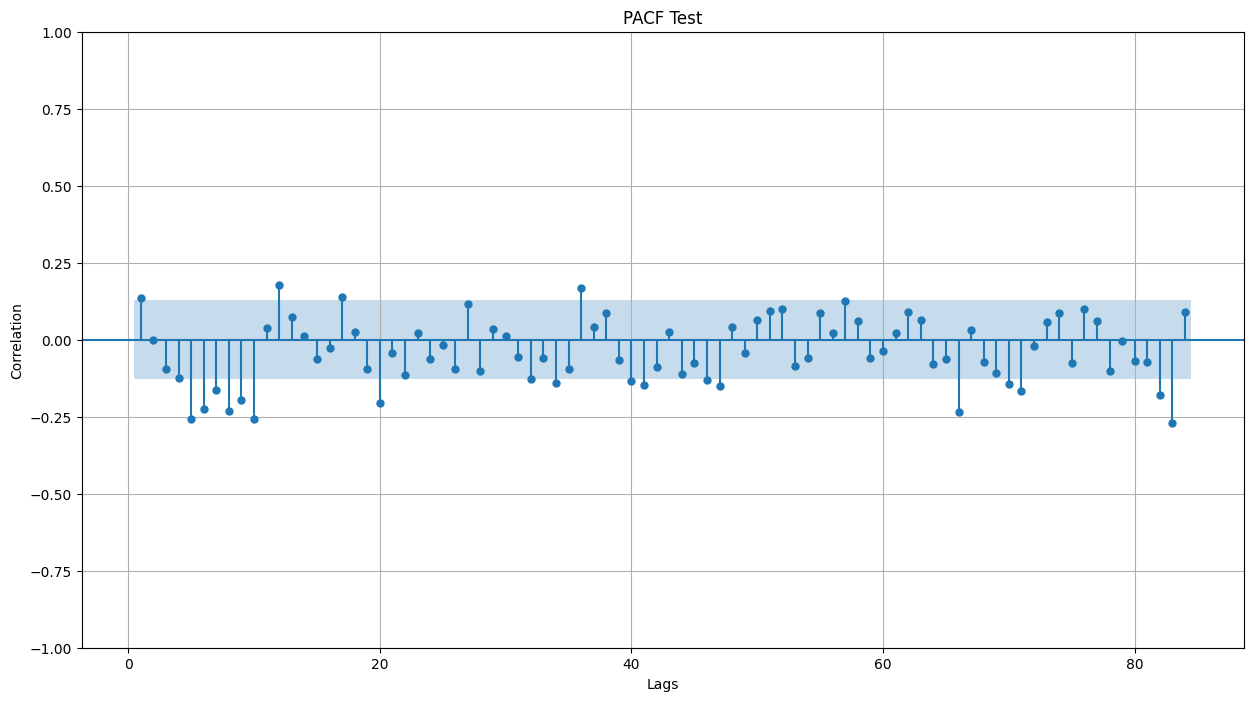

In [19]:
import statsmodels.graphics.tsaplots as sgt

sgt.plot_acf(ts.Demand, lags = 84, zero = False)
plt.title("ACF Test")
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.grid()
plt.rcParams["figure.figsize"] = (15, 8)
plt.show()

sgt.plot_pacf(ts.Demand, lags = 84, zero = False, method = 'ols')
plt.title("PACF Test")
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.grid()
plt.rcParams["figure.figsize"] = (15, 8)
plt.show()

**Deciding ARMA model parameters**

Parameter regarding AR part:
We can see from the PACF that at first there is no correlation, then some strong correlation occurs with 4-10 lags, 11 is low and
12 is high again. There are some more lags indicating correlation later on (e.g.  20, 36 etc), but we will ignore them as they will probably lead to overfitting.
So for the AR part we will use the 4, 5, 6, 7, 8, 9, 10 and 12 lags for our tests.

Parameter regarding MA part:
We can see from the ACF that is strong correlation with 4, 5, 10, 11 first lags. Again, there are some more lags indicating correlation later on (e.g.  23, 36 etc), but we will ignore them too.

In [20]:
from statsmodels.tsa.arima.model import ARIMA

# AR part parameter range
p_par = range(4, 13, 1)
# MA part parameter range
q_par = (4, 5, 10, 11)
dic = dict()
count = 0

for p in p_par:
    for q in q_par:
        order = (p, 0, q)
        model = ARIMA(ts.Demand, order=order).fit()
        pred_model = model.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
        
        mae_value = round(mae(ts_test.Demand, pred_model), 3)
        rmse_value = round(rmse(ts_test.Demand, pred_model), 3)
        x = "For the ARMA(" + str(p) + "," + str(q) + ") Trained Model's prediction, we have MAE=" + str(mae_value) + " and RMSE=" + str(rmse_value)
        dic[count] = x
        count = count + 1 

C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelih

In [21]:
for key in dic:
    print(dic[key])

For the ARMA(4,4) Trained Model's prediction, we have MAE=4.294 and RMSE=5.712
For the ARMA(4,5) Trained Model's prediction, we have MAE=3.793 and RMSE=5.09
For the ARMA(4,10) Trained Model's prediction, we have MAE=3.819 and RMSE=5.117
For the ARMA(4,11) Trained Model's prediction, we have MAE=4.234 and RMSE=5.672
For the ARMA(5,4) Trained Model's prediction, we have MAE=4.29 and RMSE=5.69
For the ARMA(5,5) Trained Model's prediction, we have MAE=3.812 and RMSE=5.105
For the ARMA(5,10) Trained Model's prediction, we have MAE=3.809 and RMSE=5.099
For the ARMA(5,11) Trained Model's prediction, we have MAE=4.212 and RMSE=5.621
For the ARMA(6,4) Trained Model's prediction, we have MAE=4.151 and RMSE=5.537
For the ARMA(6,5) Trained Model's prediction, we have MAE=3.784 and RMSE=5.063
For the ARMA(6,10) Trained Model's prediction, we have MAE=4.067 and RMSE=5.303
For the ARMA(6,11) Trained Model's prediction, we have MAE=3.75 and RMSE=5.011
For the ARMA(7,4) Trained Model's prediction, we h

C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


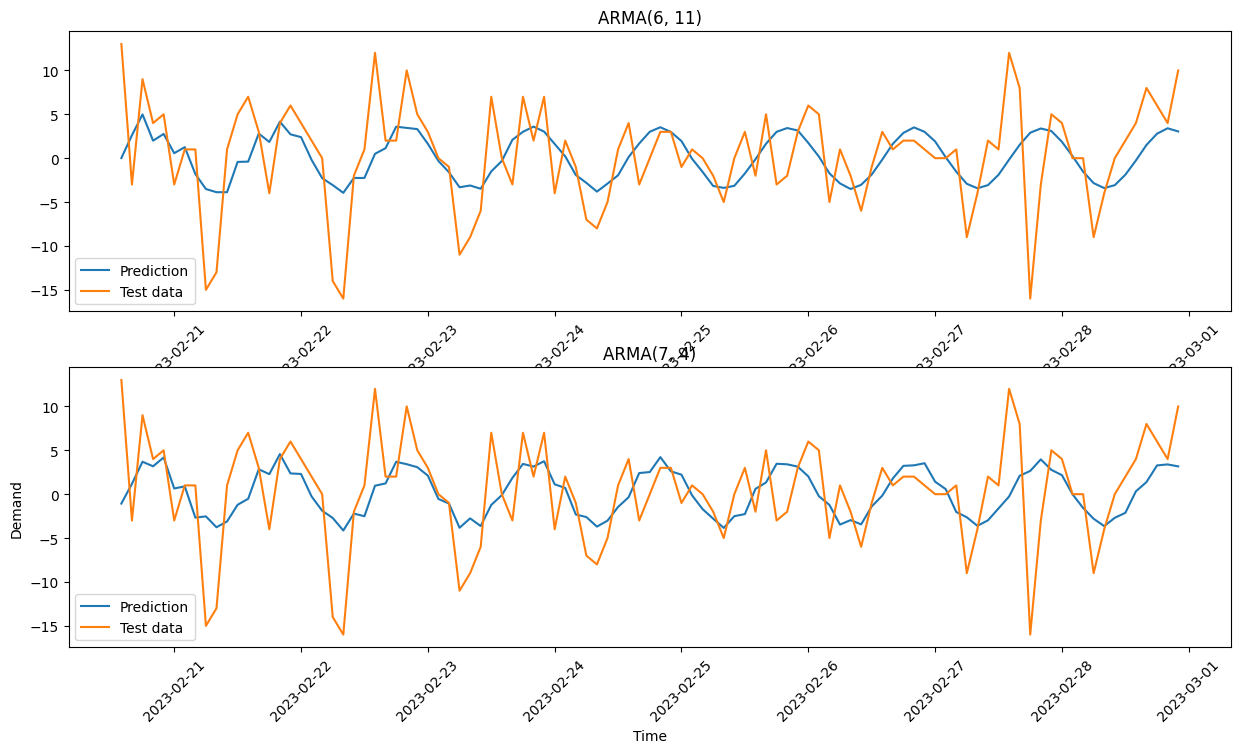

In [63]:
# ARMA(6, 11) and ARMA(7, 4) seem to be the best choices with MAE~3.74 and RMSE~5.0

order = (6, 0, 11)
ar6_ma11 = ARIMA(ts.Demand, order=order).fit()
pred_ar6_ma11 = ar6_ma11.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)

order = (7, 0, 4)
ar7_ma4 = ARIMA(ts.Demand, order=order).fit()
pred_ar7_ma4 = ar7_ma4.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)

plt.subplot(2, 1, 1)
plt.plot(pred_ar6_ma11, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARMA(6, 11)")

plt.subplot(2, 1, 2)
plt.plot(pred_ar7_ma4, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARMA(7, 4)")

plt.xlabel("Time")
plt.ylabel("Demand")

plt.savefig('./images/ts_arma_best_fits.png')
plt.show()

The above warnings could be generated for various reasons. Some common are that we should use different parameters for the model or
data is not stationary.

After ARMA model we will try the ARIMA model, as well as the SARIMA model, which we hope to address the (potential) seasonality issue

**ARIMA MODEL TEST**

In [23]:
# Trying different integration levels for AR param=6, 7 and MA param=11, 4

dic = dict()

order = (6, 1, 11)
ar6_d1_ma11 = ARIMA(ts.Demand, order=order).fit()
pred_ar6_d1_ma11 = ar6_d1_ma11.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
mae_value = mae(ts_test.Demand, pred_ar6_d1_ma11)
rmse_value = rmse(ts_test.Demand, pred_ar6_d1_ma11)
dic[0] = "For the ARIMA" + str(order) + " Trained Model's prediction we have MAE=" + str(mae_value) + " and RMSE=" + str(rmse_value)

order = (6, 2, 11)
ar6_d2_ma11 = ARIMA(ts.Demand, order=order).fit()
pred_ar6_d2_ma11 = ar6_d2_ma11.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
mae_value = mae(ts_test.Demand, pred_ar6_d2_ma11)
rmse_value = rmse(ts_test.Demand, pred_ar6_d2_ma11)
dic[1] = "For the ARIMA" + str(order) + " Trained Model's prediction we have MAE=" + str(mae_value) + " and RMSE=" + str(rmse_value)

order = (7, 1, 4)
ar7_d1_ma4 = ARIMA(ts.Demand, order=order).fit()
pred_ar7_d1_ma4 = ar7_d1_ma4.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
mae_value = mae(ts_test.Demand, pred_ar7_d1_ma4)
rmse_value = rmse(ts_test.Demand, pred_ar7_d1_ma4)
dic[2] = "For the ARIMA" + str(order) + " Trained Model's prediction we have MAE=" + str(mae_value) + " and RMSE=" + str(rmse_value)

order = (7, 2, 4)
ar7_d2_ma4 = ARIMA(ts.Demand, order=order).fit()
pred_ar7_d2_ma4 = ar7_d2_ma4.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
mae_value = mae(ts_test.Demand, pred_ar7_d2_ma4)
rmse_value = rmse(ts_test.Demand, pred_ar7_d2_ma4)
dic[3] = "For the ARIMA" + str(order) + " Trained Model's prediction we have MAE=" + str(mae_value) + " and RMSE=" + str(rmse_value)

C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  wa

In [24]:
for key in dic:
    print(dic[key])

For the ARIMA(6, 1, 11) Trained Model's prediction we have MAE=4.535653014292965 and RMSE=5.78266793030667
For the ARIMA(6, 2, 11) Trained Model's prediction we have MAE=4.502438264538122 and RMSE=5.935443700187428
For the ARIMA(7, 1, 4) Trained Model's prediction we have MAE=4.311733764577183 and RMSE=5.668875486332885
For the ARIMA(7, 2, 4) Trained Model's prediction we have MAE=4.367310398709144 and RMSE=5.838921003714416


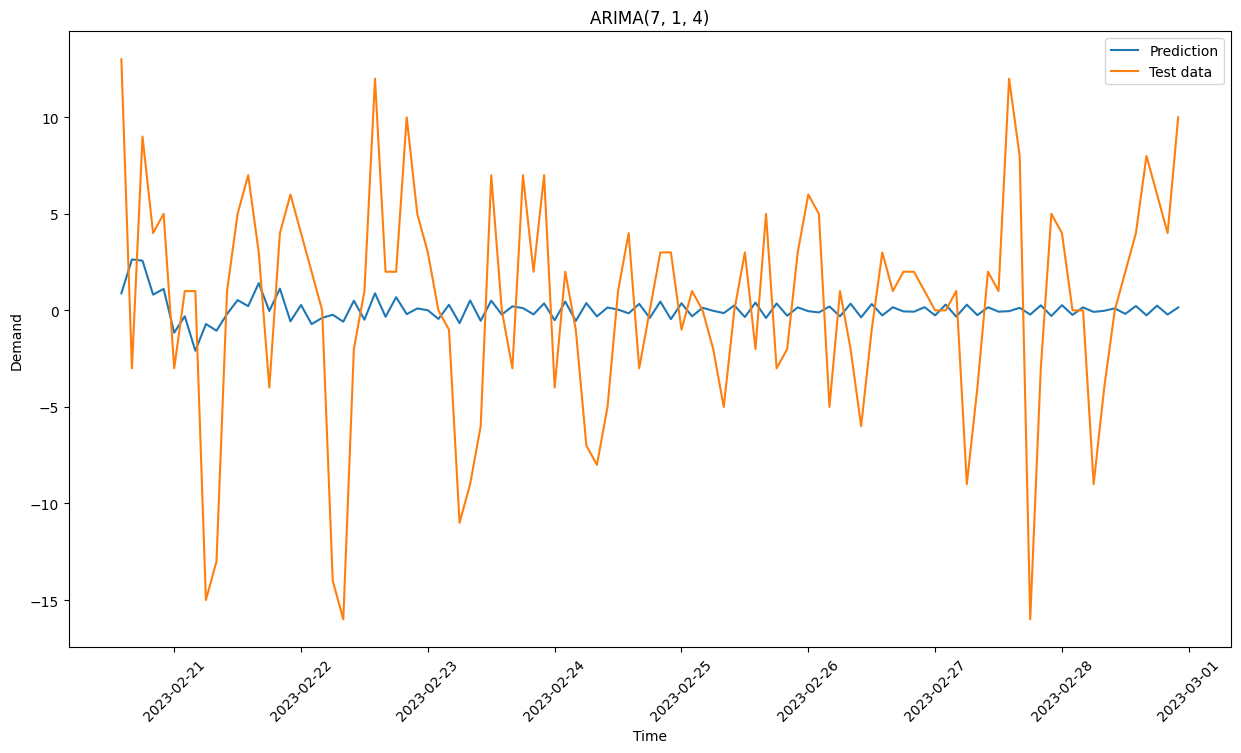

In [64]:
# Best ARIMA model from the above seems to be the ARIMA(7, 1, 4)

plt.plot(pred_ar7_d1_ma4, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.title("ARIMA(7, 1, 4)")
plt.show()

We actually did not expect the ARIMA model to perform better than ARMA model, as ARIMA offers to address trend issues,
and there is no kind of trend to be addressed in our data.

**SARIMA MODEL TEST**

In case seasonality exists and plays important role in our time series, then we hope SARIMA model will take this into account
and will give us better predictions.

In [26]:
from pmdarima import auto_arima

# Trying to get best for our model with auto_arima function
# m = 12 because the seasonality we expect is daily, which is every 12 observations (1 observation/ 2 hours)
model = auto_arima(y = ts.Demand, m = 12)
print(model)

 ARIMA(0,0,0)(2,0,0)[12]          


Best SARIMA model fit found to be ARIMA(0,0,0)(2,0,0)[12]
For the ARIMA(0,0,0)(2,0,0)[12] Model's prediction we have MAE= 4.285991545741913  and RMSE= 5.665937629186874


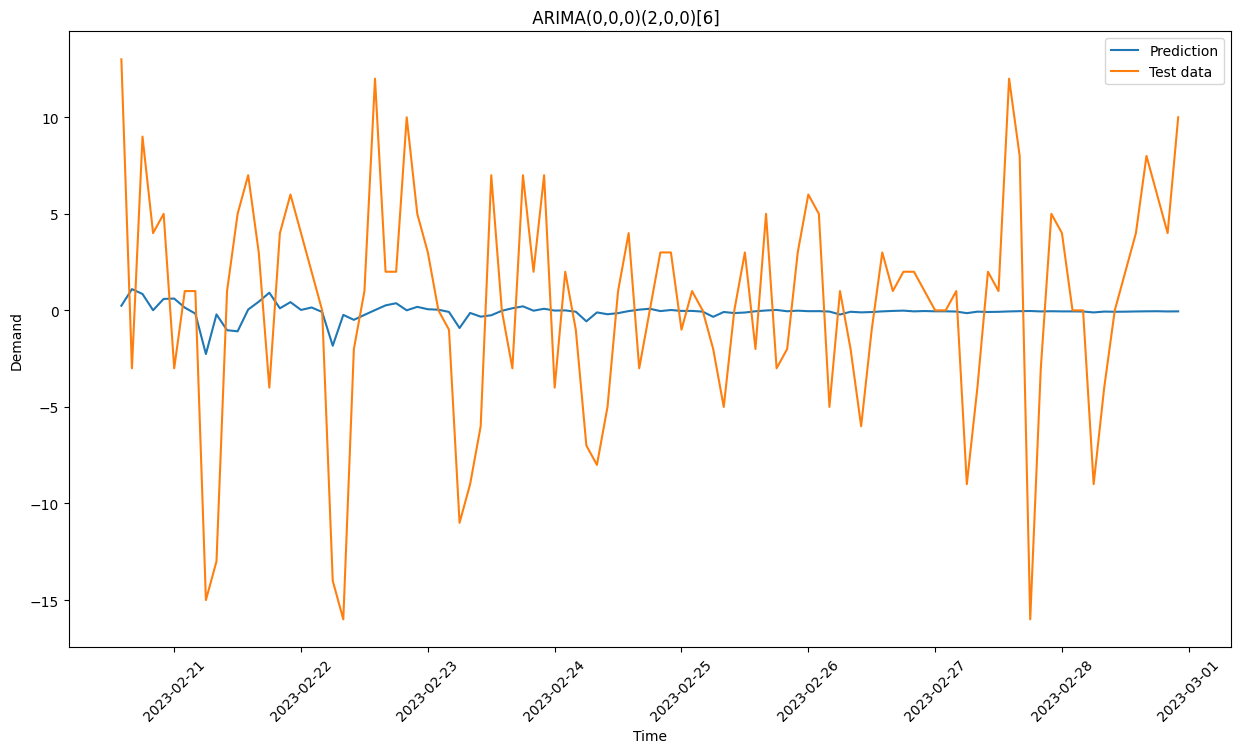

In [65]:
print("Best SARIMA model fit found to be ARIMA(0,0,0)(2,0,0)[12]")

sarima_model = ARIMA(ts.Demand, order=(0,0,0), seasonal_order=(2,0,0,12)).fit()
pred_sarima = sarima_model.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
mae_value = mae(ts_test.Demand, pred_sarima)
rmse_value = rmse(ts_test.Demand, pred_sarima)
print("For the ARIMA(0,0,0)(2,0,0)[12] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))
plt.plot(pred_sarima, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.title(model)
plt.show()

Lets try different SARIMA parameters to see if we will have better results.

C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


For the ARIMA(10,0,12)(2,0,0)[12] Model's prediction we have MAE= 3.8541646894383343  and RMSE= 5.206549792345831


C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


For the ARIMA(6,0,11)(2,0,0)[12] Model's prediction we have MAE= 4.2356913324269545  and RMSE= 5.644518017178454


C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


For the ARIMA(7,0,4)(2,0,0)[12] Model's prediction we have MAE= 3.7933598357194787  and RMSE= 5.112186345344961
For the ARIMA(10,0,1)(2,0,0)[12] Model's prediction we have MAE= 4.244529583758737  and RMSE= 5.607801073043189


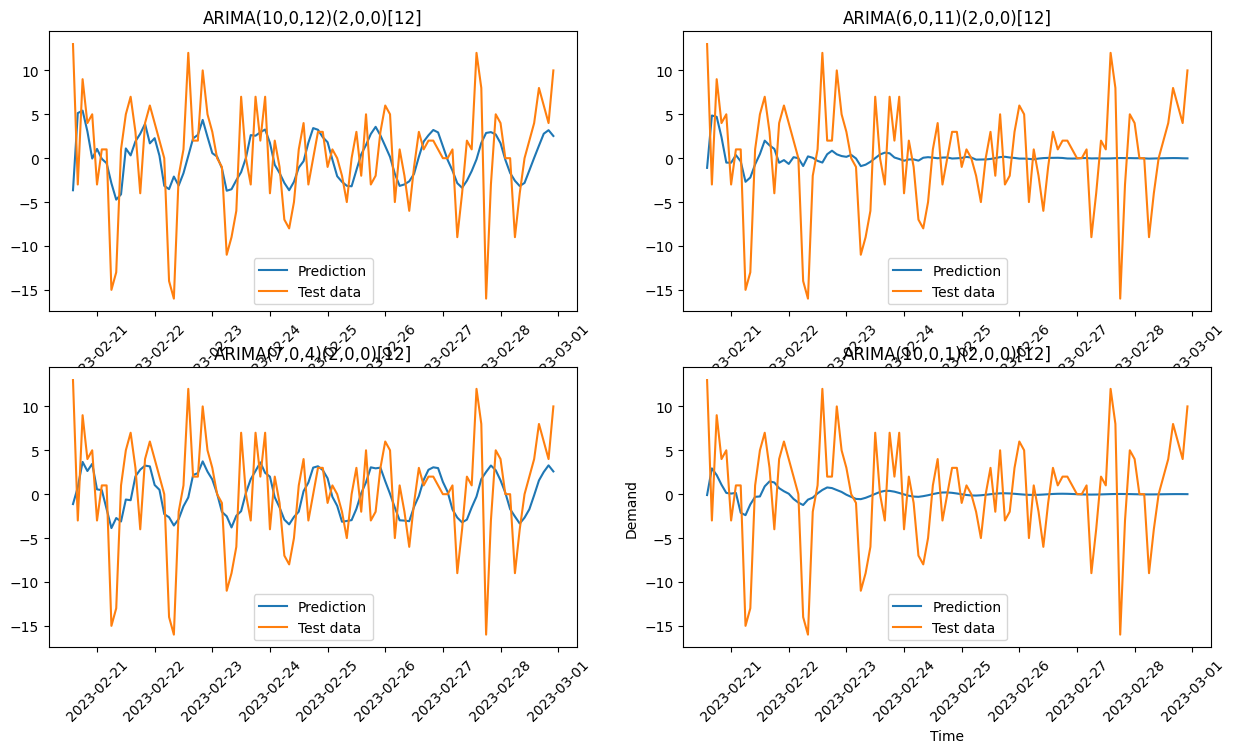

In [67]:
sar10_ima12 = ARIMA(ts.Demand, order=(10,0,12), seasonal_order=(2,0,0,12)).fit()
pred_sar10_ima12 = sar10_ima12.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
mae_value = mae(ts_test.Demand, pred_sar10_ima12)
rmse_value = rmse(ts_test.Demand, pred_sar10_ima12)
print("For the ARIMA(10,0,12)(2,0,0)[12] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

sar6_ima11 = ARIMA(ts.Demand, order=(6,0,11), seasonal_order=(2,0,0,12)).fit()
pred_sar6_ima11 = sar6_ima11.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
mae_value = mae(ts_test.Demand, pred_sar6_ima11)
rmse_value = rmse(ts_test.Demand, pred_sar6_ima11)
print("For the ARIMA(6,0,11)(2,0,0)[12] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

sar7_ima4 = ARIMA(ts.Demand, order=(7,0,4), seasonal_order=(2,0,0,12)).fit()
pred_sar7_ima4 = sar7_ima4.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
mae_value = mae(ts_test.Demand, pred_sar7_ima4)
rmse_value = rmse(ts_test.Demand, pred_sar7_ima4)
print("For the ARIMA(7,0,4)(2,0,0)[12] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

sar10_ima1 = ARIMA(ts.Demand, order=(10,0,1), seasonal_order=(2,0,0,12)).fit()
pred_sar10_ima1 = sar10_ima1.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
mae_value = mae(ts_test.Demand, pred_sar10_ima1)
rmse_value = rmse(ts_test.Demand, pred_sar10_ima1)
print("For the ARIMA(10,0,1)(2,0,0)[12] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

plt.subplot(2, 2, 1)
plt.plot(pred_sar10_ima12, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARIMA(10,0,12)(2,0,0)[12]")

plt.subplot(2, 2, 2)
plt.plot(pred_sar6_ima11, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARIMA(6,0,11)(2,0,0)[12]")

plt.subplot(2, 2, 3)
plt.plot(pred_sar7_ima4, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARIMA(7,0,4)(2,0,0)[12]")

plt.subplot(2, 2, 4)
plt.plot(pred_sar10_ima1, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARIMA(10,0,1)(2,0,0)[12]")

plt.xlabel("Time")
plt.ylabel("Demand")

plt.show()

Lets test the ARIMA(7,0,4)(2,0,0)[12], but with different integration levels to see if it will result in better prediciton

C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


For the ARIMA(7,1,4)(2,0,0)[12] Model's prediction we have MAE= 4.296809024137582  and RMSE= 5.661905326325487


C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


For the ARIMA(7,2,4)(2,0,0)[12] Model's prediction we have MAE= 4.522562563292177  and RMSE= 5.8011749835359705


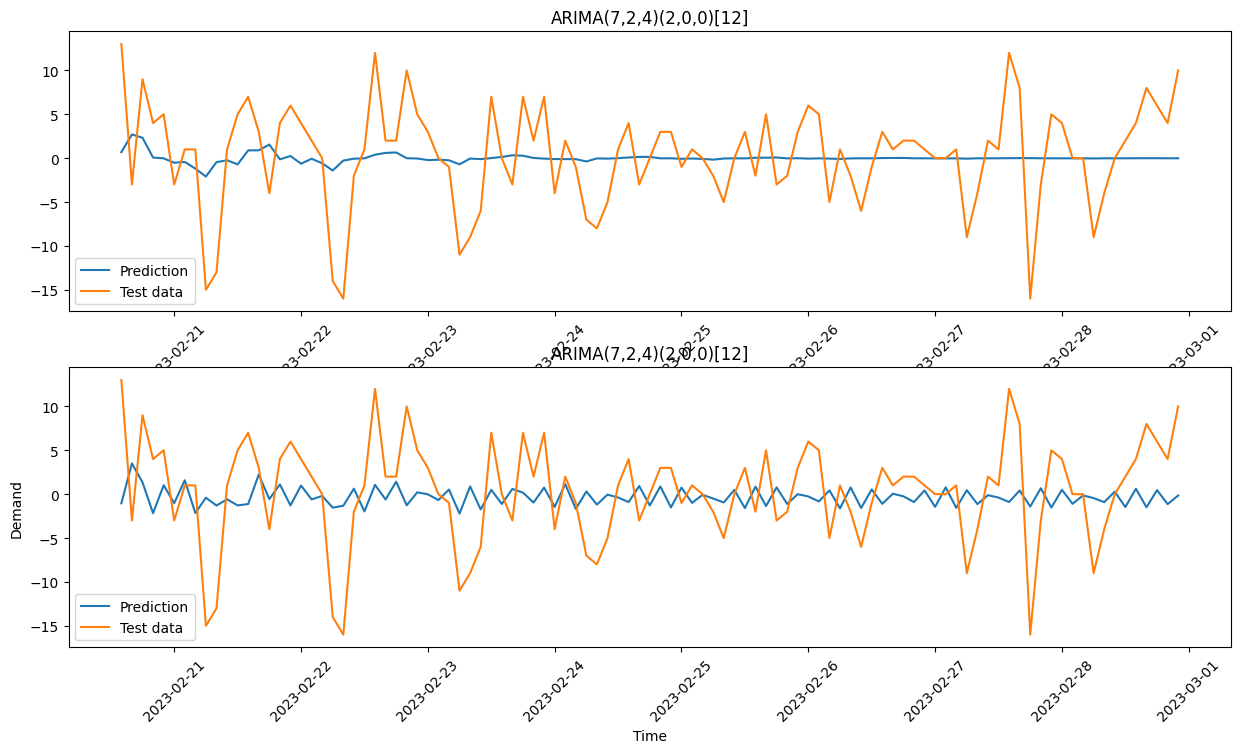

In [68]:
sar7_i1_ma4 = ARIMA(ts.Demand, order=(7,1,4), seasonal_order=(2,0,0,12)).fit()
pred_sar7_i1_ma4 = sar7_i1_ma4.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
mae_value = mae(ts_test.Demand, pred_sar7_i1_ma4)
rmse_value = rmse(ts_test.Demand, pred_sar7_i1_ma4)
print("For the ARIMA(7,1,4)(2,0,0)[12] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

sar7_i2_ma4 = ARIMA(ts.Demand, order=(7,2,4), seasonal_order=(2,0,0,12)).fit()
pred_sar7_i2_ma4 = sar7_i2_ma4.predict(start=len(ts), end=len(time_serie)-1, dynamic=False)
mae_value = mae(ts_test.Demand, pred_sar7_i2_ma4)
rmse_value = rmse(ts_test.Demand, pred_sar7_i2_ma4)
print("For the ARIMA(7,2,4)(2,0,0)[12] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

plt.subplot(2, 1, 1)
plt.plot(pred_sar7_i1_ma4, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARIMA(7,2,4)(2,0,0)[12]")

plt.subplot(2, 1, 2)
plt.plot(pred_sar7_i2_ma4, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARIMA(7,2,4)(2,0,0)[12]")

plt.xlabel("Time")
plt.ylabel("Demand")

plt.show()

After some tests the (S)ARIMA (0,0,4)(8,0,1)[12] Model was found to be the best prediction model,.

In [30]:
sar08_ima41 = ARIMA(ts.Demand, order=(0,0,4), seasonal_order=(8,0,1,12)).fit()
pred_sar08_ima41 = sar08_ima41.forecast(len(ts_test.Demand))
mae_value = round(mae(ts_test.Demand, pred_sar08_ima41), 3)
rmse_value = round(rmse(ts_test.Demand, pred_sar08_ima41), 3)
print("For the ARIMA(0,0,4)(8,0,1)[12] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

For the ARIMA(0,0,4)(8,0,1)[12] Model's prediction we have MAE= 2.984  and RMSE= 4.095


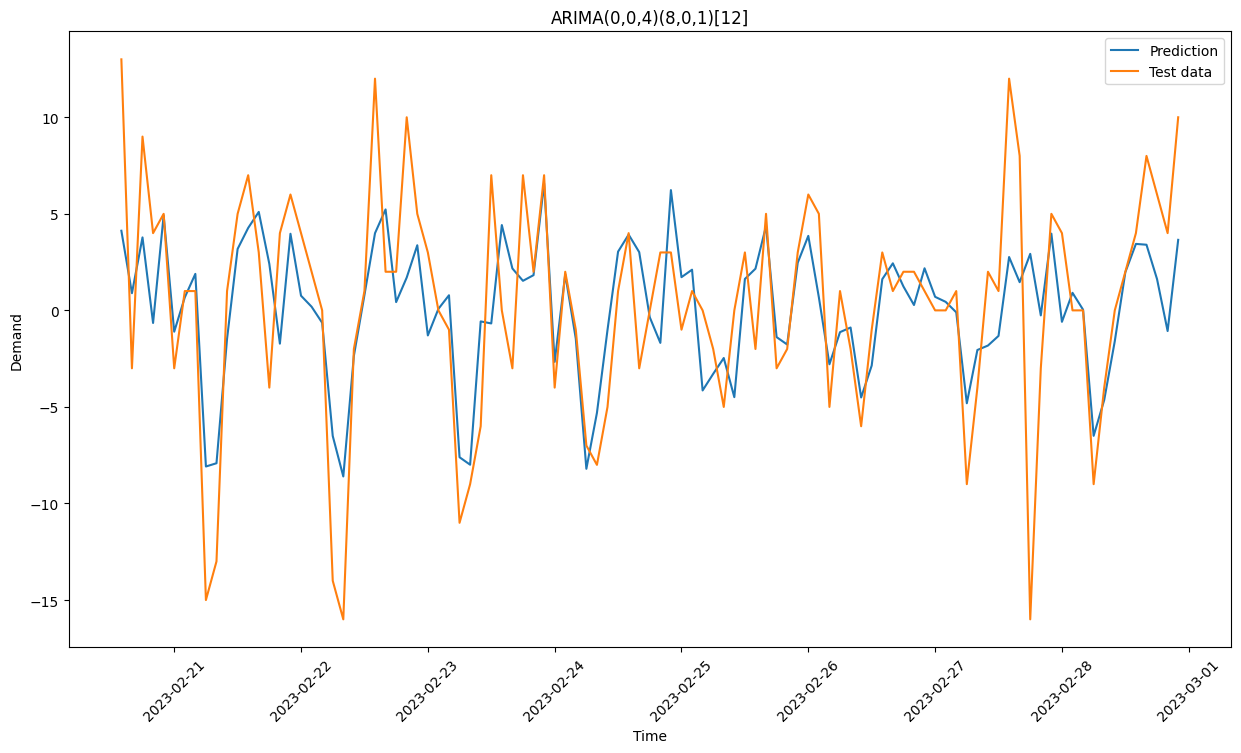

In [69]:
plt.plot(pred_sar08_ima41, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARIMA(0,0,4)(8,0,1)[12]")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.savefig('./images/ts_sarima_best_fit.png')
plt.show()

The result above also suggests that daily seasonality indeed plays important role in our predictions.<br>
The AR, integration and MA parameters on the other hand could not be foreseen. Neither ACF nor PACF gave us strong indications to use the above,
so we had to find the best model by testing various combinations to make the model better and better.

**SIMPLE EXPONENTIAL SMOOTHING MODEL**

MAE: 4.43 RMSE: 5.836


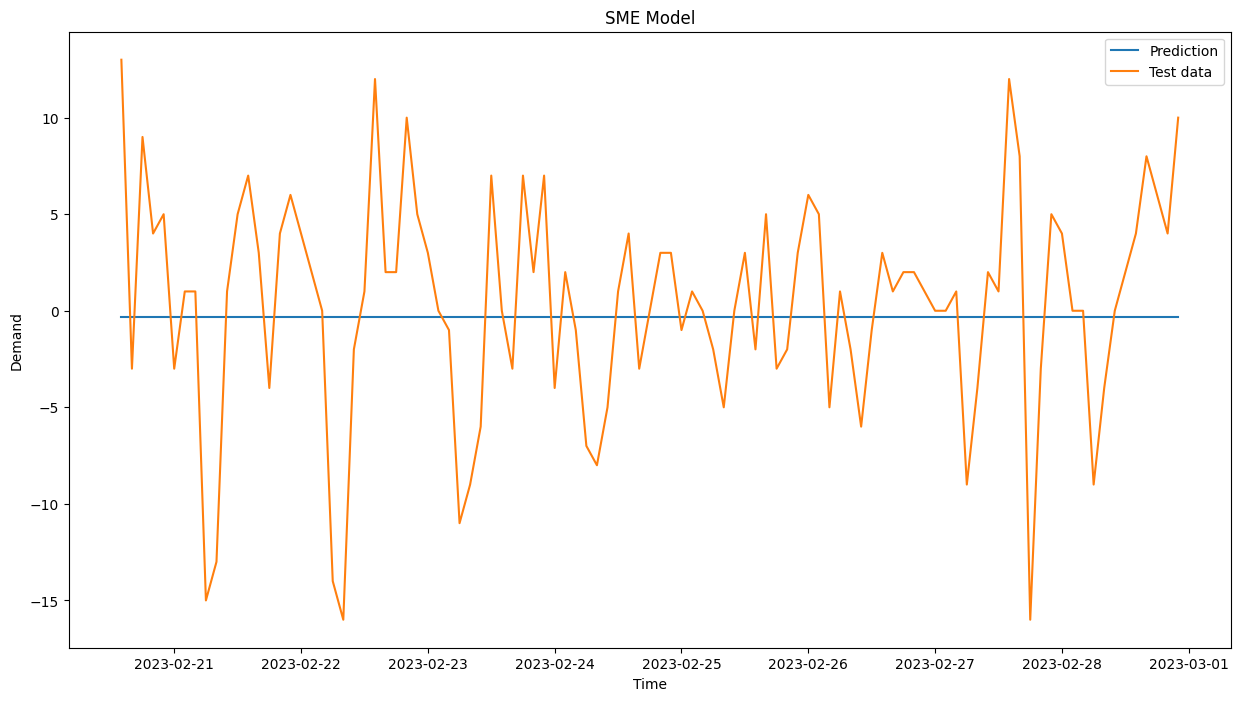

In [70]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

sme_model = SimpleExpSmoothing(ts.Demand).fit(optimized=True)
sme_pred = sme_model.forecast(len(ts_test))

mae_value = round(mae(ts_test.Demand, sme_pred), 3)
rmse_value = round(rmse(ts_test.Demand, sme_pred), 3)
print("MAE:", mae_value, "RMSE:", rmse_value)
plt.plot(sme_pred, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.legend()
plt.title("SME Model")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.show()

**TRIPLE EXPONENTIAL SMOOTHING MODEL**

MAE: 3.206 RMSE: 4.206


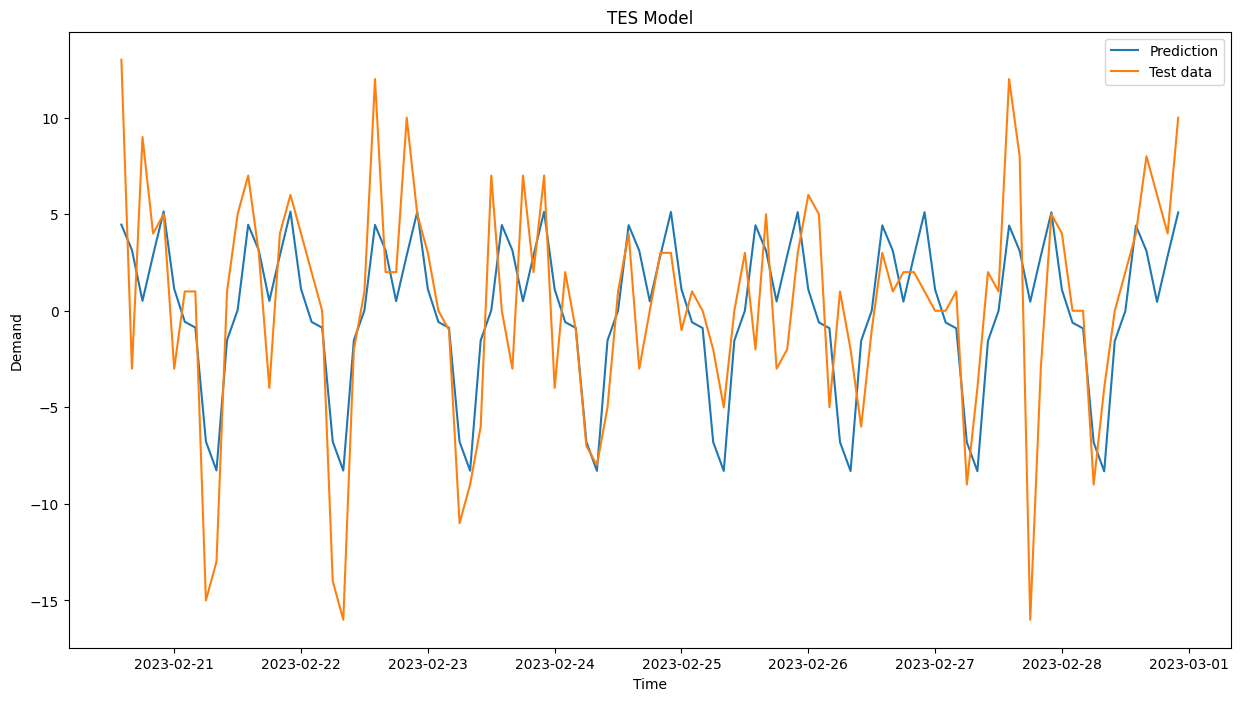

In [71]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

tes_model = ExponentialSmoothing(ts.Demand, trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)
tes_pred = tes_model.forecast(len(ts_test))

mae_value = round(mae(ts_test.Demand, tes_pred), 3)
rmse_value = round(rmse(ts_test.Demand, tes_pred), 3)
print("MAE:", mae_value, "RMSE:", rmse_value)
plt.plot(tes_pred, label="Prediction")
plt.plot(ts_test.Demand, label="Test data")
plt.legend()
plt.title("TES Model")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.savefig('./images/ts_tes.png')
plt.show()

We can see that the Holt Winter's Method (Triple Exponential Smoothing), gave us a prediction very close the the previous SARIMA.<br>
Once again here, TES confirms us that the initially potential observed seasonality is strong enough to help us get better predictions.

## **USING SARIMA AND TSE ON SAME DATA WITH DIFFERENT FREQUENCY IN CALCULATED OBSERVATIONS**

In [34]:
time_serie2 = csvDataToTimeSerie('data.csv', 4)
ts2, ts_test2 = timeSerieSplit(time_serie2, 0.7, 0.3)

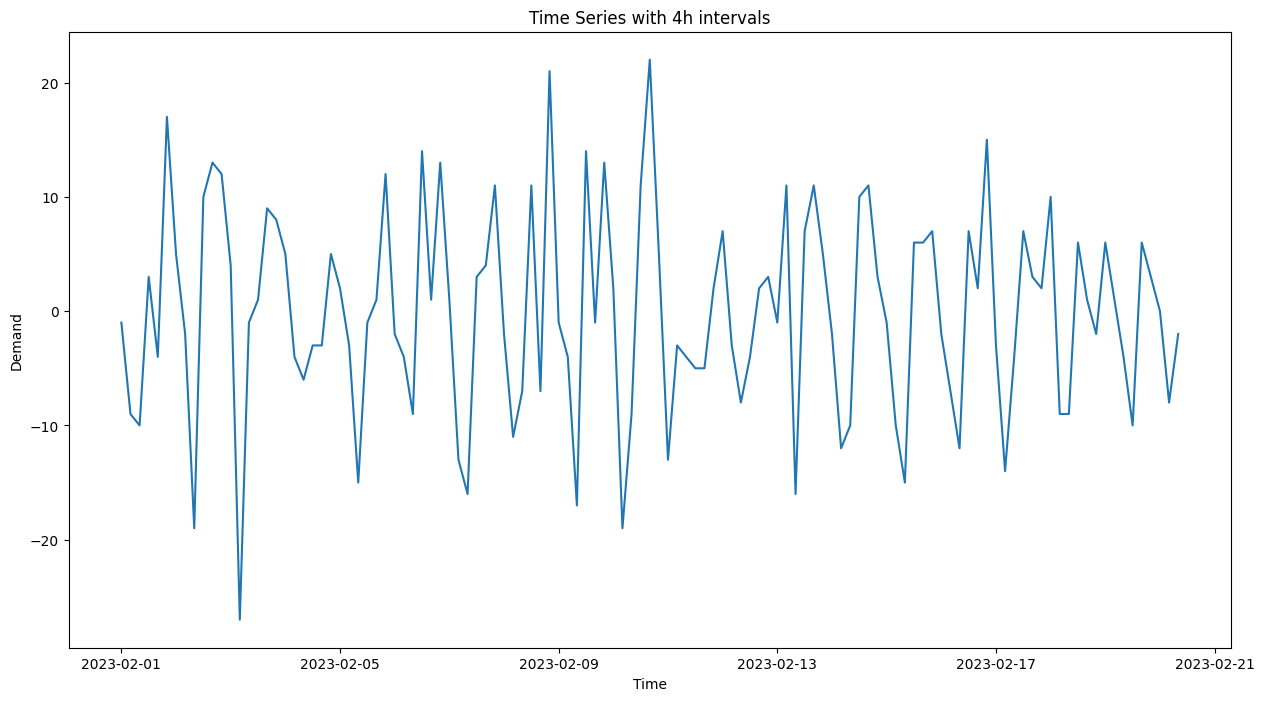

In [35]:
plt.plot(ts2)
plt.title("Time Series with 4h intervals")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.savefig('./images/ts_4h_intervals.png')
plt.show()

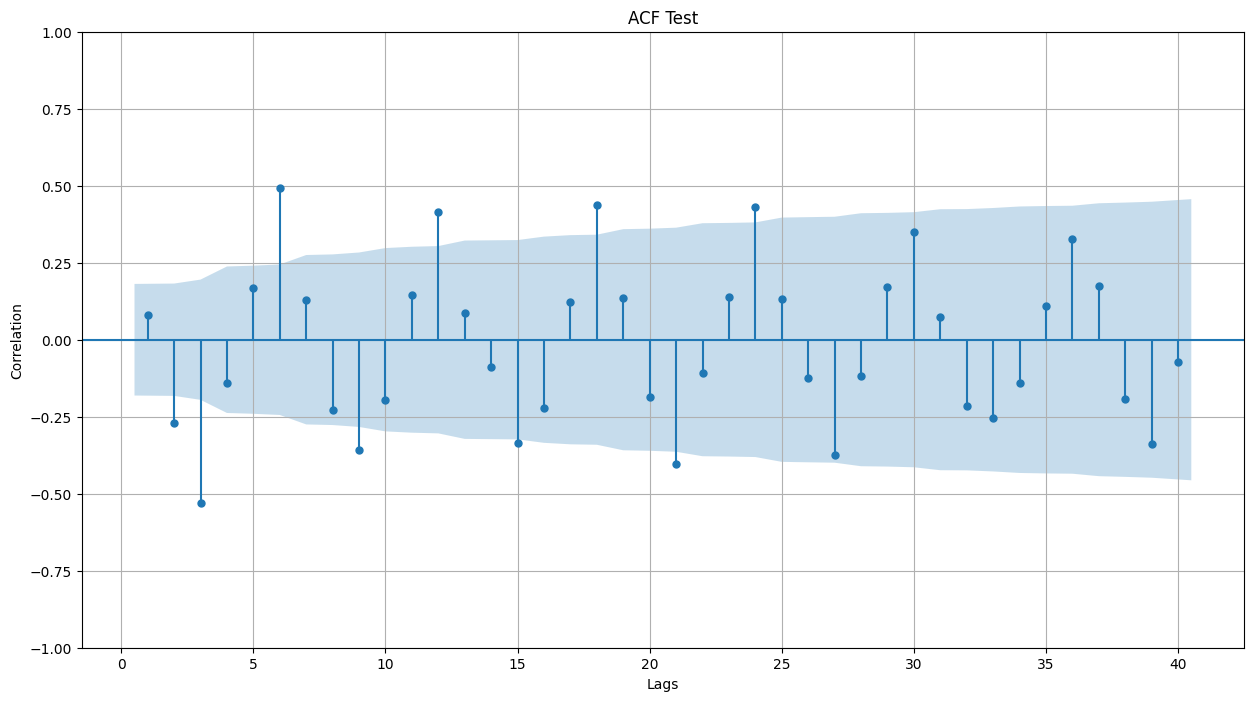

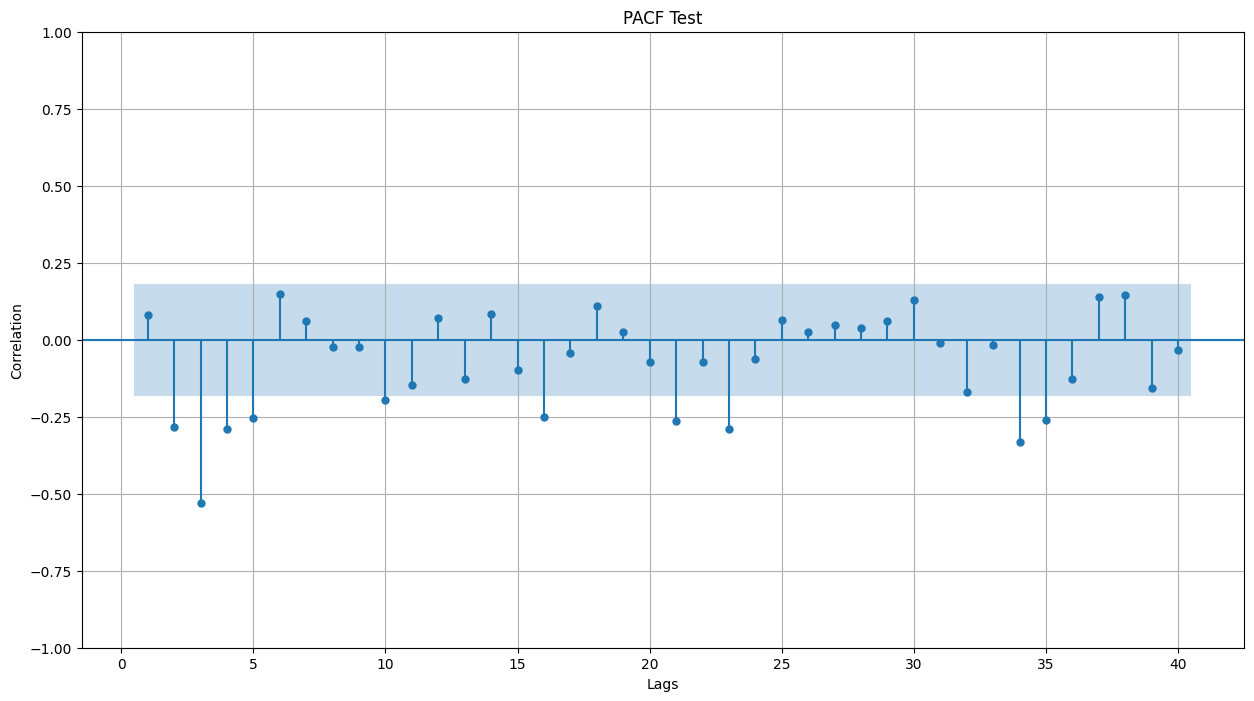

In [36]:
sgt.plot_acf(ts2, lags = 40, zero = False)
plt.title("ACF Test")
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.grid()
plt.rcParams["figure.figsize"] = (15, 8)
plt.savefig('./images/ts2_acf.png')
plt.show()

sgt.plot_pacf(ts2, lags = 40, zero = False, method = 'ols')
plt.title("PACF Test")
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.grid()
plt.rcParams["figure.figsize"] = (15, 8)
plt.savefig('./images/ts2_pacf.png')
plt.show()

Again, we suspect from the ACF a seasonality of 6 lags (daily seasonality).
Also, both ACF and PACF gives a strong correlation with the 3rd lag (indicating a 12-hour seasonlity), 
which was not so obvious with the 2-hour interval time series.

So, for the AR part of the ARIMA model, it would be a good choice to pick AR parameter=3 and MA parameter=6.
We will also use the auto_arima method to see what will it also suggest.

In [37]:
model = auto_arima(y = ts2, m = 6)
print(model)

 ARIMA(0,0,0)(2,0,0)[6]          


Best SARIMA model fit found to be ARIMA(0,0,0)(2,0,0)[6]
For the ARIMA(0,0,0)(2,0,0)[6] Model's prediction we have MAE= 6.919  and RMSE= 8.428


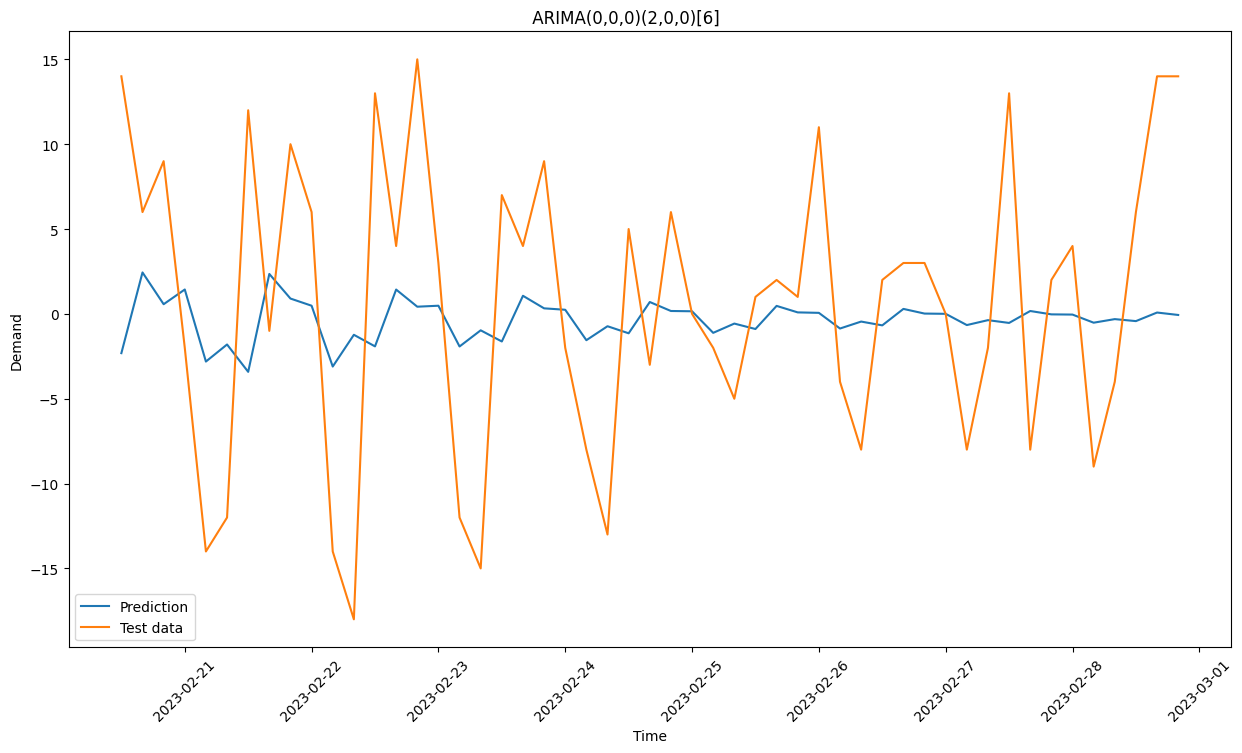

In [72]:
print("Best SARIMA model fit found to be ARIMA(0,0,0)(2,0,0)[6]")

sarima_model = ARIMA(ts2, order=(0,0,0), seasonal_order=(2,0,0,6)).fit()
pred_sarima = sarima_model.forecast(len(ts_test2))
mae_value = round(mae(ts_test2, pred_sarima), 3)
rmse_value = round(rmse(ts_test2, pred_sarima), 3)
print("For the ARIMA(0,0,0)(2,0,0)[6] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))
plt.plot(pred_sarima, label="Prediction")
plt.plot(ts_test2, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title(model)
plt.show()

Now we will try some more SARIMA models with different parameters.

For the ARIMA(0,0,3)(2,0,0)[6] Model's prediction we have MAE= 6.648427781694107  and RMSE= 8.103636036062662
For the ARIMA(3,0,3)(2,0,0)[6] Model's prediction we have MAE= 6.803555920276157  and RMSE= 8.246821565755619


C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


For the ARIMA(0,0,6)(2,0,0)[6] Model's prediction we have MAE= 6.603039825304068  and RMSE= 8.031625599075566


C:\Users\panag\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


For the ARIMA(3,0,6)(2,0,0)[6] Model's prediction we have MAE= 5.178925347069028  and RMSE= 6.3833693478147655


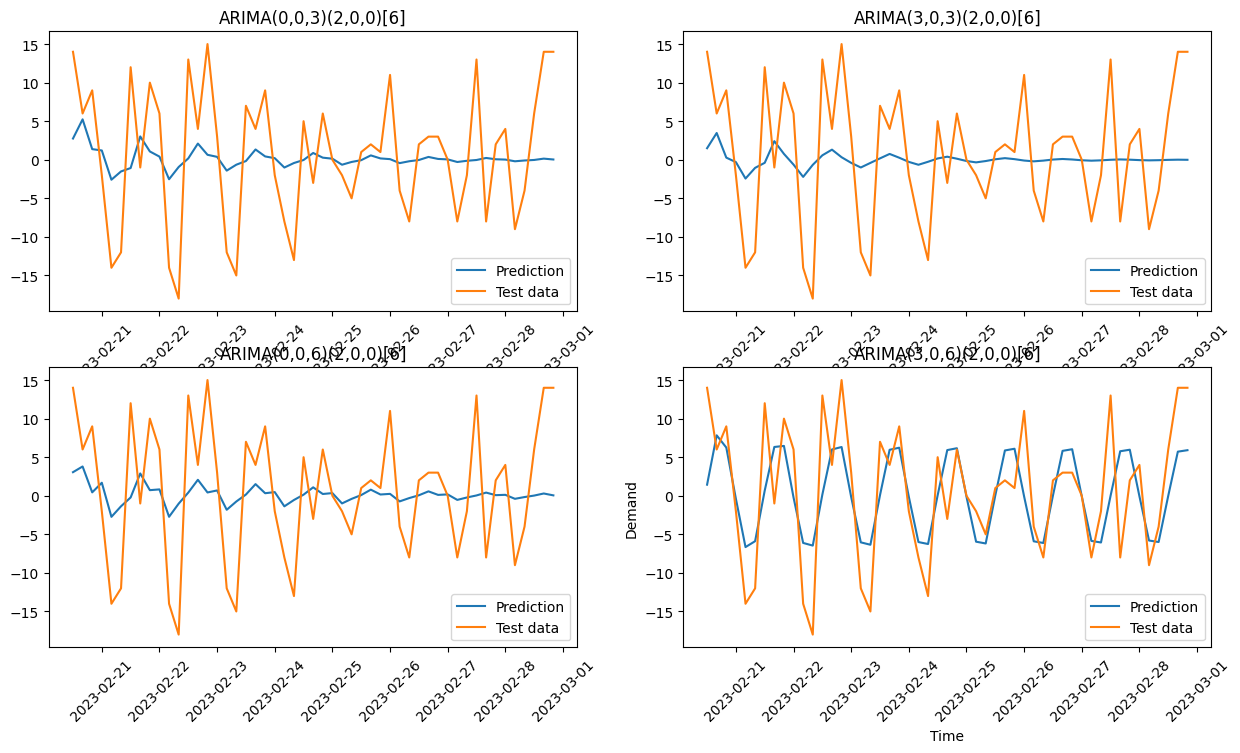

In [73]:
sar0_ima3 = ARIMA(ts2, order=(0,0,3), seasonal_order=(2,0,0,6)).fit()
pred_sar0_ima3 = sar0_ima3.forecast(len(ts_test2))
mae_value = mae(ts_test2, pred_sar0_ima3)
rmse_value = rmse(ts_test2, pred_sar0_ima3)
print("For the ARIMA(0,0,3)(2,0,0)[6] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

sar3_ima3 = ARIMA(ts2, order=(3,0,3), seasonal_order=(2,0,0,6)).fit()
pred_sar3_ima3 = sar3_ima3.forecast(len(ts_test2))
mae_value = mae(ts_test2, pred_sar3_ima3)
rmse_value = rmse(ts_test2, pred_sar3_ima3)
print("For the ARIMA(3,0,3)(2,0,0)[6] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

sar0_ima6 = ARIMA(ts2, order=(0,0,6), seasonal_order=(2,0,0,6)).fit()
pred_sar0_ima6 = sar0_ima6.forecast(len(ts_test2))
mae_value = mae(ts_test2, pred_sar0_ima6)
rmse_value = rmse(ts_test2, pred_sar0_ima6)
print("For the ARIMA(0,0,6)(2,0,0)[6] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

sar3_ima6 = ARIMA(ts2, order=(3,0,6), seasonal_order=(2,0,0,6)).fit()
pred_sar3_ima6 = sar3_ima6.forecast(len(ts_test2))
mae_value = mae(ts_test2, pred_sar3_ima6)
rmse_value = rmse(ts_test2, pred_sar3_ima6)
print("For the ARIMA(3,0,6)(2,0,0)[6] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

plt.subplot(2, 2, 1)
plt.plot(pred_sar0_ima3, label="Prediction")
plt.plot(ts_test2, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARIMA(0,0,3)(2,0,0)[6]")

plt.subplot(2, 2, 2)
plt.plot(pred_sar3_ima3, label="Prediction")
plt.plot(ts_test2, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARIMA(3,0,3)(2,0,0)[6]")

plt.subplot(2, 2, 3)
plt.plot(pred_sar0_ima6, label="Prediction")
plt.plot(ts_test2, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARIMA(0,0,6)(2,0,0)[6]")

plt.subplot(2, 2, 4)
plt.plot(pred_sar3_ima6, label="Prediction")
plt.plot(ts_test2, label="Test data")
plt.legend()
plt.xticks(rotation=45)
plt.title("ARIMA(3,0,6)(2,0,0)[6]")

plt.xlabel("Time")
plt.ylabel("Demand")

plt.show()

After some tests the (S)ARIMA (0,0,0)(3,0,1)[6] Model was found to be the best prediction model

In [40]:
sar12_i01_ma01 = ARIMA(ts2, order=(1,0,0), seasonal_order=(2,1,1,6)).fit()
pred_sar12_i01_ma01 = sar12_i01_ma01.forecast(len(ts_test2))
mae_value = round(mae(ts_test2, pred_sar12_i01_ma01), 3)
rmse_value = round(rmse(ts_test2, pred_sar12_i01_ma01), 3)
print("For the ARIMA(1,0,0)(2,1,1)[6] Model's prediction we have MAE=", str(mae_value), " and RMSE=", str(rmse_value))

For the ARIMA(1,0,0)(2,1,1)[6] Model's prediction we have MAE= 4.179  and RMSE= 5.204


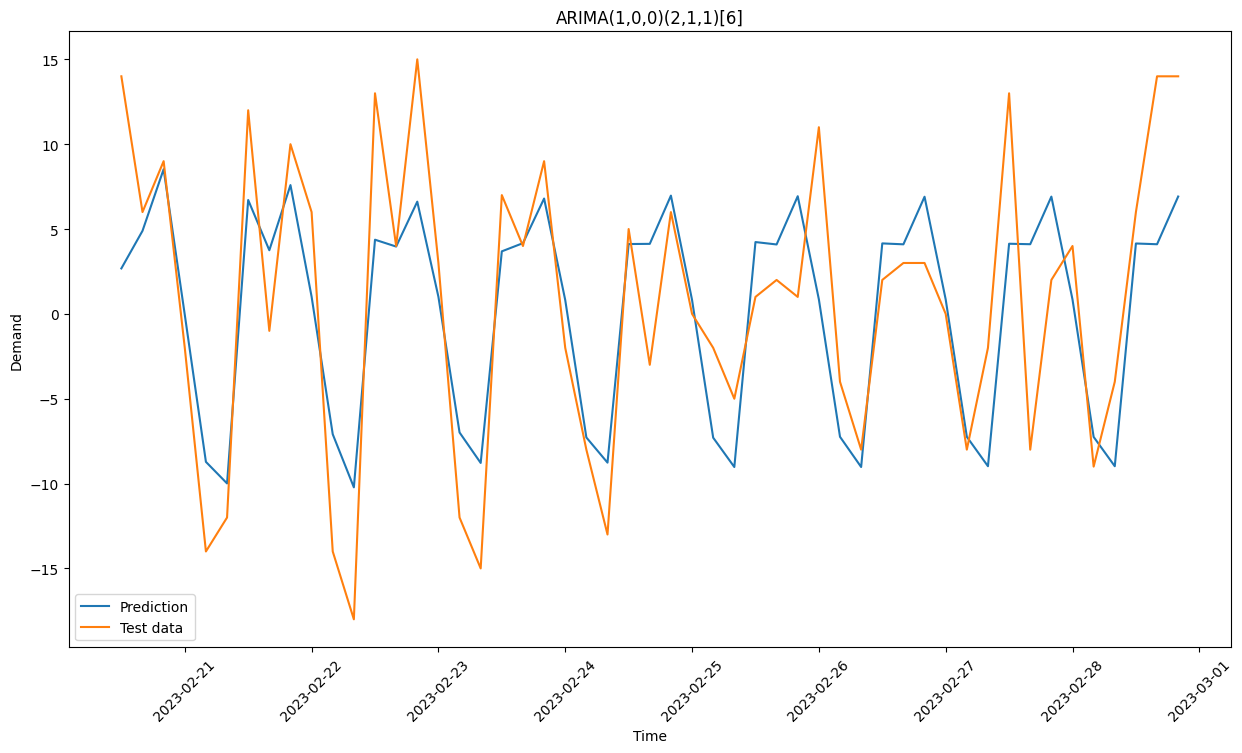

In [74]:
plt.plot(pred_sar12_i01_ma01, label="Prediction")
plt.plot(ts_test2, label="Test data")
plt.xticks(rotation=45)
plt.legend()
plt.title("ARIMA(1,0,0)(2,1,1)[6]")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.savefig('./images/ts2_sarima_best_fit.png')
plt.show()

Now we will try Triple Exponential Smoothing

MAE: 4.234 RMSE: 5.237


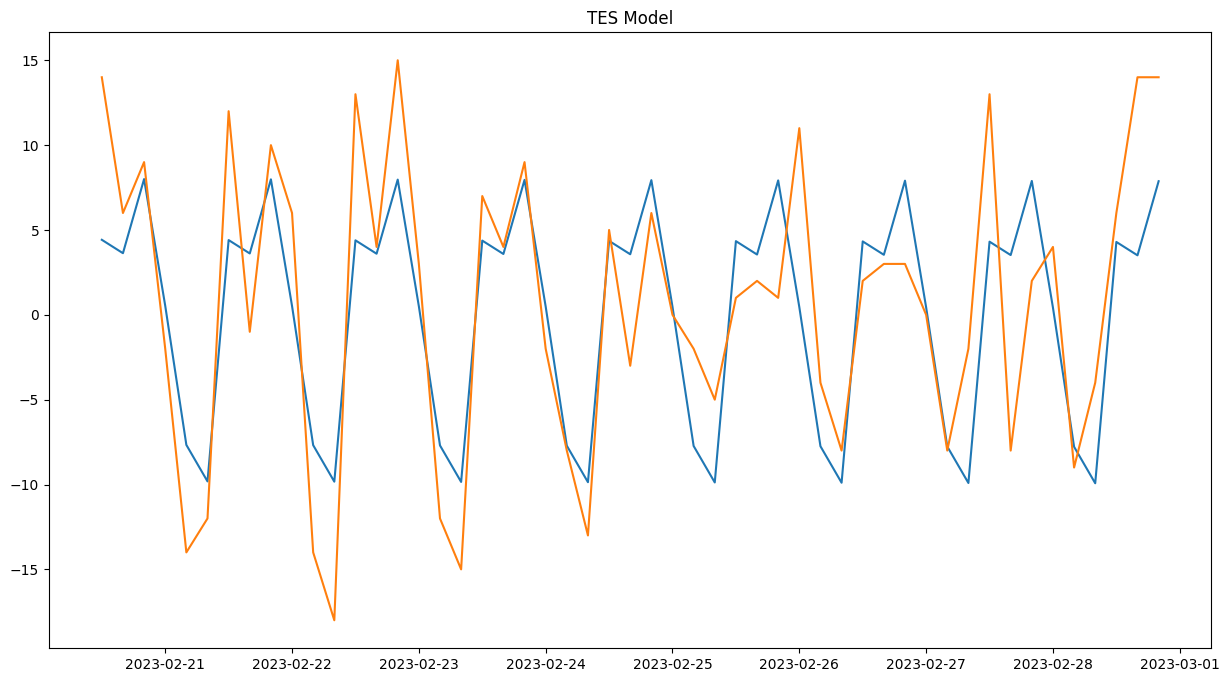

In [42]:
tes2_model = ExponentialSmoothing(ts2, trend='add', seasonal='add', seasonal_periods=6).fit(optimized=True)
tes2_pred = tes2_model.forecast(len(ts_test2))

mae_value = round(mae(ts_test2, tes2_pred), 3)
rmse_value = round(rmse(ts_test2, tes2_pred), 3)
print("MAE:", mae_value, "RMSE:", rmse_value)
plt.plot(tes2_pred, label="Prediction")
plt.plot(ts_test2.Demand, label="Test data")
plt.legend()
plt.title("TES Model")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.savefig('./images/ts2_tes.png')
plt.show()

## **RESULTS SUMMARY**

I created two different time series for the tests. The first, in which I performed most of the tests, had 2 hour intervals, 
and the second, in which I performed only spesific tests, had 4 hour intervals.

**Analysis for the time series with 2 hour intervals**

**Training data plot**

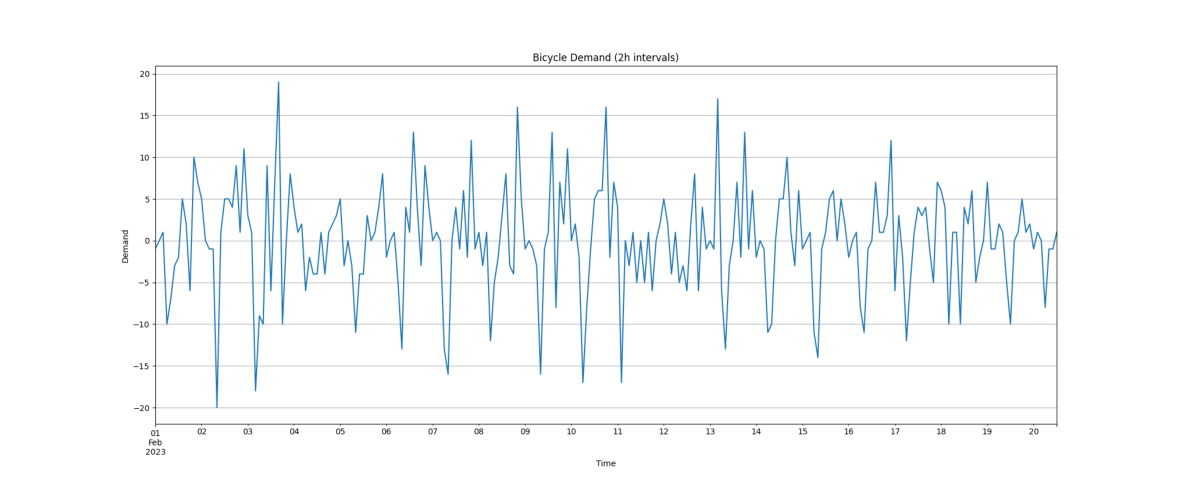

In [43]:
img = mpimg.imread('./images/ts_2h_intervals.png')
plt.imshow(img)
plt.axis('off')
plt.show()

I observed that the time series looks a little like white noise.<br>
I also observed that there may exist daily seasonality, but it does not seem strong enough for us to be certain that it playes important role for our predictions. Seasonality existense should be examined further.<br>
As for trend, it is clear that it does not exist.<br>
I then plotted ACF and PACF, trying to get more information for the time series.

**ACF and PACF plot**

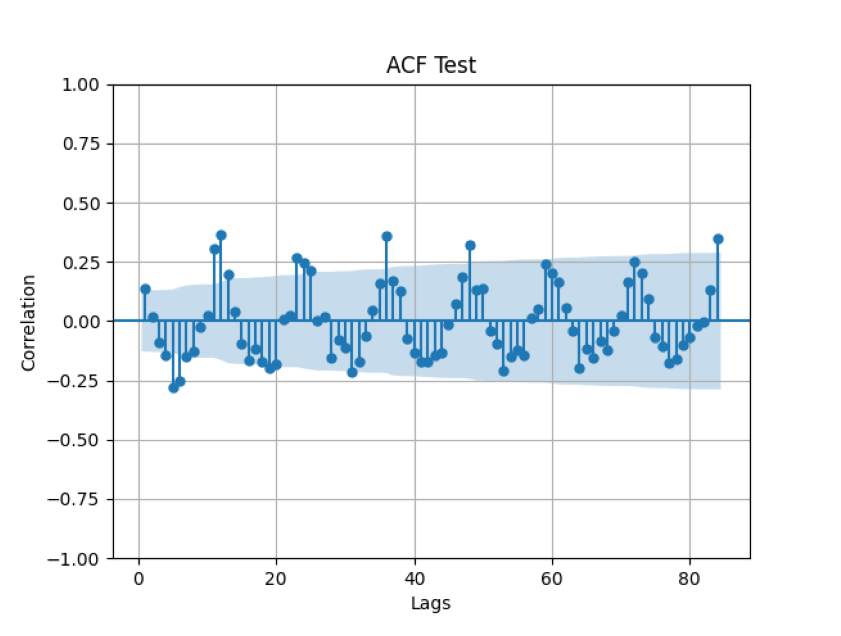

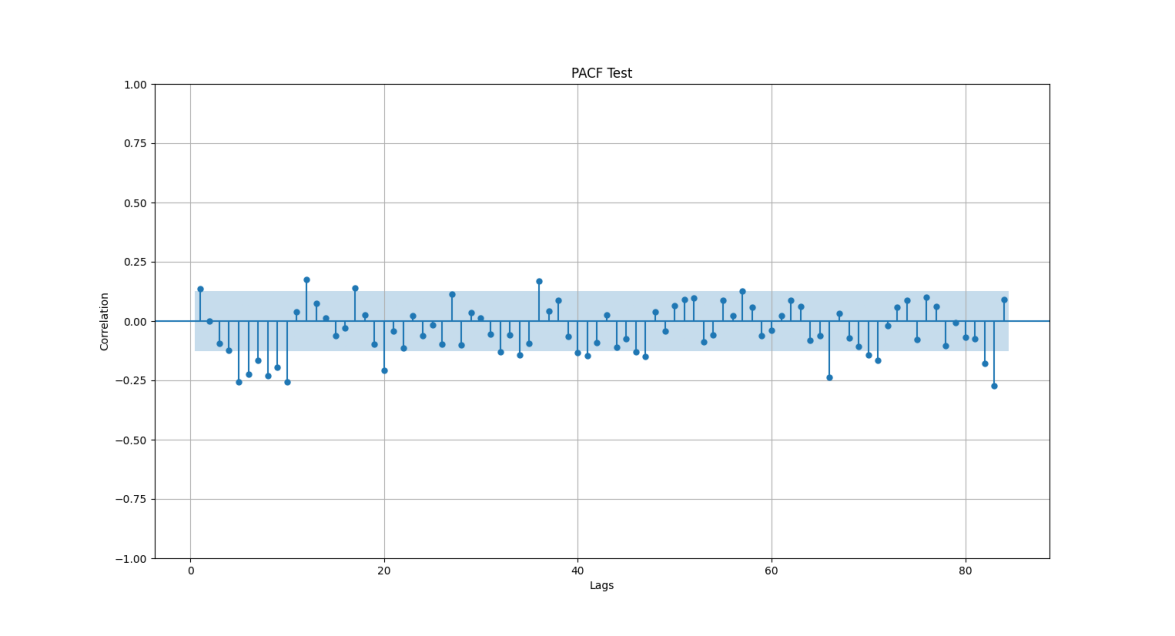

In [44]:
img = mpimg.imread('./images/acf_for_ts.png')
plt.imshow(img)
plt.axis('off')
plt.show()

img = mpimg.imread('./images/pacf_for_ts.png')
plt.imshow(img)
plt.axis('off')
plt.show()

Both ACF and PACF plot did not have certain spikes clearly stronger than the rest.<br>
They both suggested some correlation for some lags. This information will be used for AR, ARMA and ARIMA initial parameters choice.<br>
ACF plot also shows a periodic pattern, suggesting that there is daily seasonality (potentially making our data non-stationary).<br>
I then tried the Augmented Dickey-Fuller test, to get more information for the time series' stationarity

**ADF test**

In [45]:
print("ADF Statistic for the ts: ", adf_ts[0])
print("p-value for the ts: ", adf_ts[1], "\n")

ADF Statistic for the ts:  -6.037258260877346
p-value for the ts:  1.3726001974839793e-07 



The test showed that the time series is most likely stationary, failing to capture the seasonality (if any).<br>
Having the indication of stationarity for the time series, I decided to try models that work well only on stationary ts (that is before I try models that can capture seasonality too).<br>
First of the models tested is the Auto-regressive Model (AR).<br>
Best guesses for the AR Model parameter are the lags that showed strong correlation in the PACF plot. I tried some parameters and got the following best errors from the prediction of each model, along with each model's forecasting plot.

**AR Model test results**

MAE AR(10): 4.179
RMSE AR(10): 5.535 

MAE AR(12): 4.187
RMSE AR(12): 5.521 



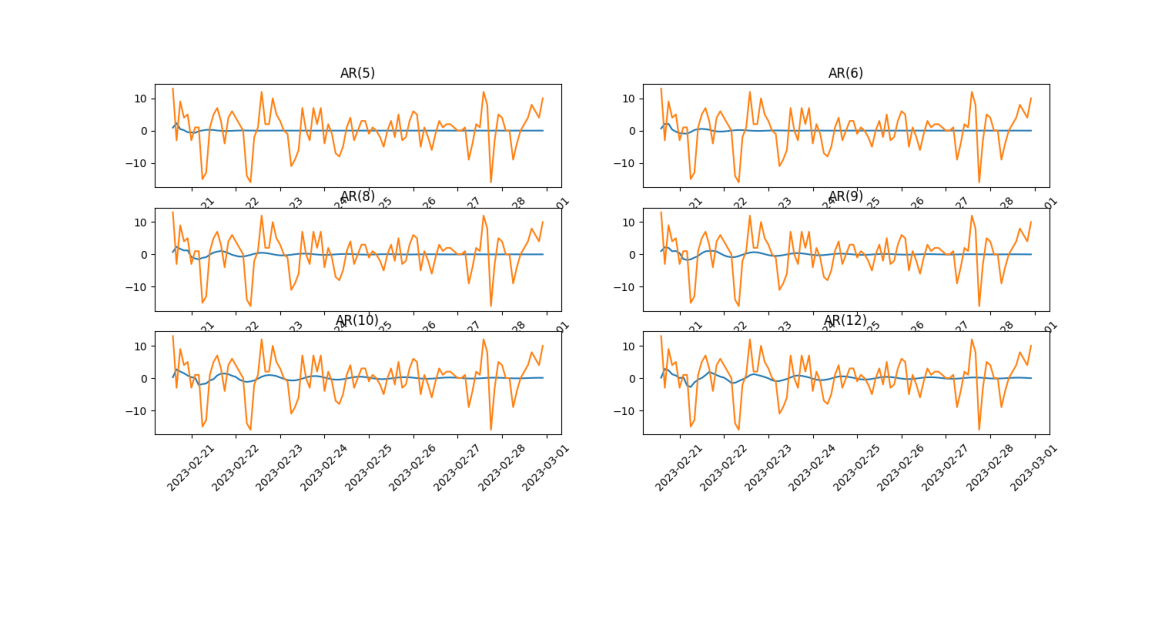

In [46]:
print("MAE AR(10):", round(mae(ts_test.Demand, pred_ts_ar10), 3))
print("RMSE AR(10):", round(rmse(ts_test.Demand, pred_ts_ar10), 3), "\n")

print("MAE AR(12):", round(mae(ts_test.Demand, pred_ts_ar12), 3))
print("RMSE AR(12):", round(rmse(ts_test.Demand, pred_ts_ar12), 3), "\n")

img = mpimg.imread('./images/ts_ar_models.png')
plt.imshow(img)
plt.axis('off')
plt.show()

Some models seem to give better predictions than others,
but overall it is clear from the plots that the predictions do not follow the test data at all, and we should not depend on any of them.<br>
After some tests I saw that AR(45)'s prediction gave a pretty good error.

MAE AR(45): 3.892
RMSE AR(45) 5.135 



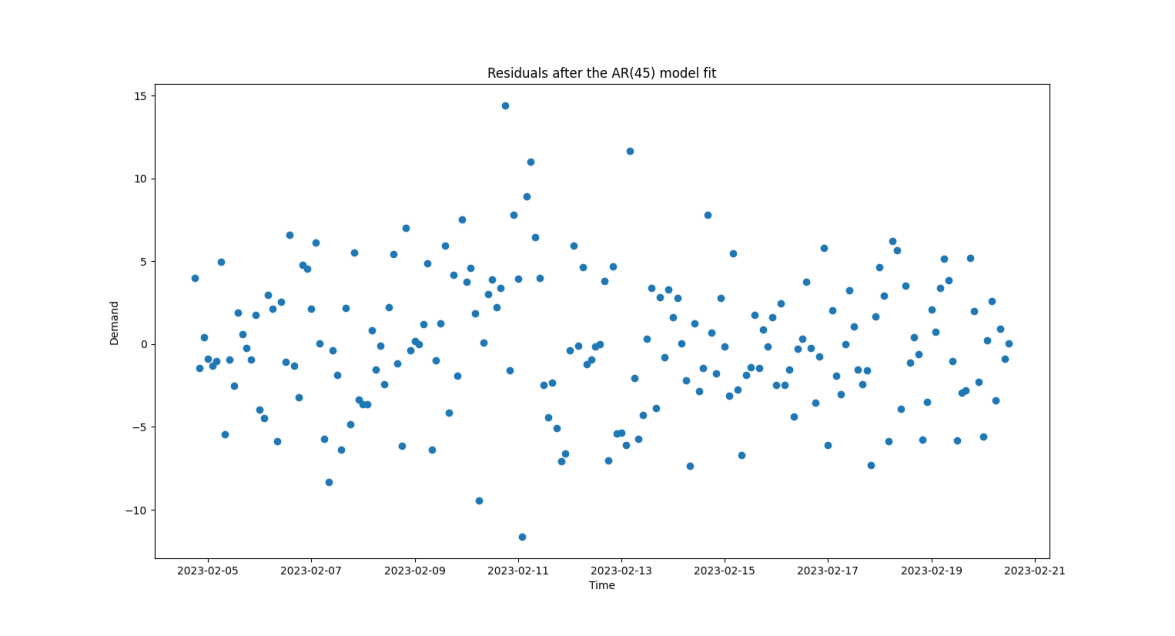

In [47]:
print("MAE AR(45):", round(mae(ts_test.Demand, pred_ts_ar45), 3))
print("RMSE AR(45)", round(rmse(ts_test.Demand, pred_ts_ar45), 3), "\n")

img = mpimg.imread('./images/ts_ar45_residuals.png')
plt.imshow(img)
plt.axis('off')
plt.show()

But observing the residuals of the model, it is clear that they are not gathered around 0 at all. They are scattered all over the place, and this should indicate that this model is not good, and that we got a misleading good prediction because of overfitting.<br>
After the AR model, I tried the Auto-Regressive Moving Average (ARMA) model. Again, for the tests, I picked parameters for AR part based on the PACF. Parameters for the MA part were picked based on the ACF.<br>
The tests showed that ARMA(6, 11) and ARMA(7, 4) were the best choices with MAE~3.74 and RMSE~5.0 for both.<br>

**ARMA Model test results**

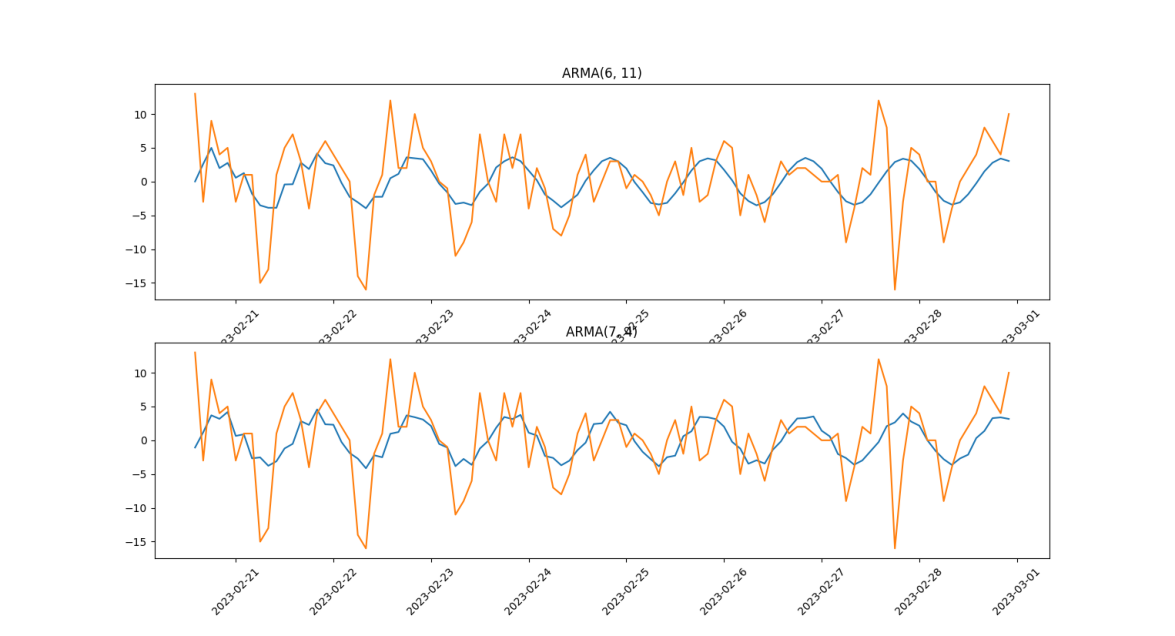

In [48]:
img = mpimg.imread('./images/ts_arma_best_fits.png')
plt.imshow(img)
plt.axis('off')
plt.show()

Judging by the plots and the errors, we can see that best ARMA model fits slightly accomplish to follow the test data's ups and downs, but it is clear again that the predictions are not good enough and we should examine other models too.<br>
<br>
Next model to try was the Auto-Regressive Integrated Moving Average (ARIMA). The main difference between ARMA and ARIMA is that the ARIMA can handle non-stationary data (unless non-stationarity is because of seasonality existence) by applying differencing.<br>
I tested various ARIMA model fits and I also tried to get the "best" ARIMA fit using the auto_arima method from the pdarima library, but all predictions made by the models were not a good upgrade of the best ARMA models I found earlier.<br>
This was not a surprise at all, because ARIMA offers to address trend and variance issues, which did not exist in our model.<br>
<br>
Next model to try was the Seasonal Auto-Regressive Integrated Moving Average (SARIMA), with which I hoped to capture the supposed seasonality component of the time series and use it for the predictions.<br>
Like with previous models, in the first tests I performed using the SARIMA model, I used parameters based on the ACF, PACF plots. The sesonality parameter was kept at 12 lags because it is clear that if there is a seasonality that has a strong presence, then it is clearly daily seasonality.<br>
The initial tests gave bad predictions. I then started testing as many different parameter values I could, trying to get the best model, and I concluded that the ARIMA(0,0,4)(8,0,1)[12] gave the best predictions, until now, by far.

**SARIMA Model test results**

MAE ARIMA(0,0,4)(8,0,1)[12]: 2.984
RMSE ARIMA(0,0,4)(8,0,1)[12]: 4.095 



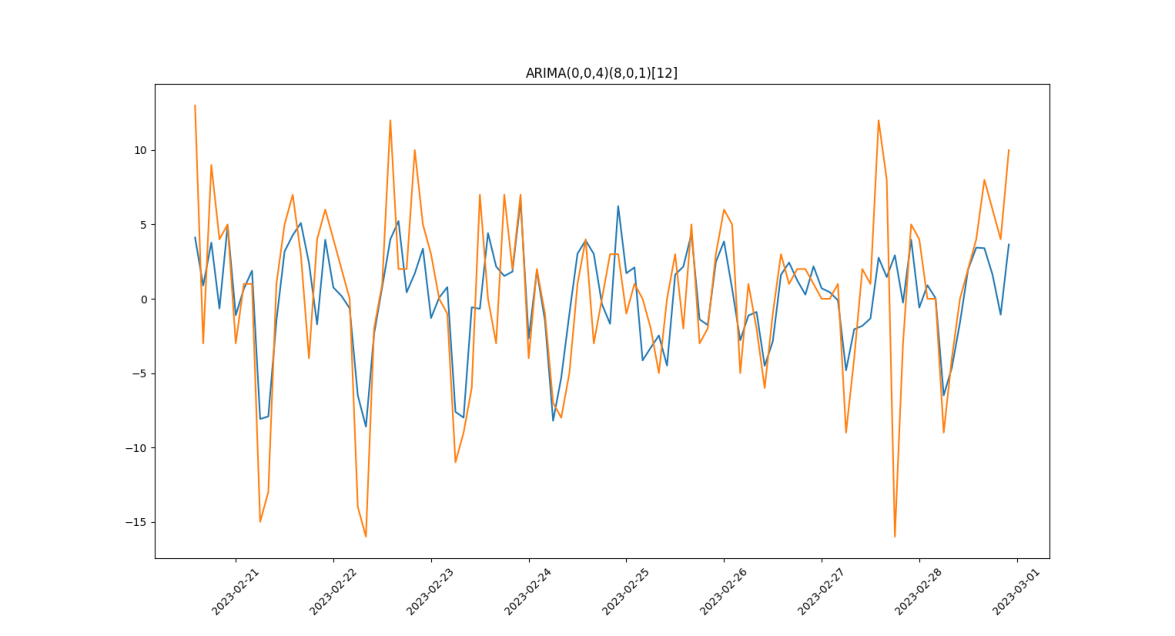

In [49]:
print("MAE ARIMA(0,0,4)(8,0,1)[12]:", round(mae(ts_test.Demand, pred_sar08_ima41), 3))
print("RMSE ARIMA(0,0,4)(8,0,1)[12]:", round(rmse(ts_test.Demand, pred_sar08_ima41), 3), "\n")

img = mpimg.imread('./images/ts_sarima_best_fit.png')
plt.imshow(img)
plt.axis('off')
plt.show()

As we can see from the MAE, RMSE and plot, accounting for seasonality by using the SARIMA model paid off in the end.<br>
There is a certain downwards spike at the end of the test data that was poorly predicted, but we should not worry a lot about this, because judging by the periodic downward spikes at the rest of the data, it did not follow the overall pattern.<br>
<br>
After that I used Exponential Smoothing Models for our predictions.<br>
At first I tried Simple Exponential Smoothing which of course gave a very poor prediction.<br>
Double Exponential Smoothing was not tested at all, as it offers to deal with trend, which does not exists in our data.<br>
Triple Exponential Smoothing on the other hand, offers to deal with seasonality too. Using TES by assuming daily seasonality we got a pretty good prediction.

**TES Model test results**

MAE Triple Exponential Smoothing: 3.206
RMSE Triple Exponential Smoothing: 4.206 



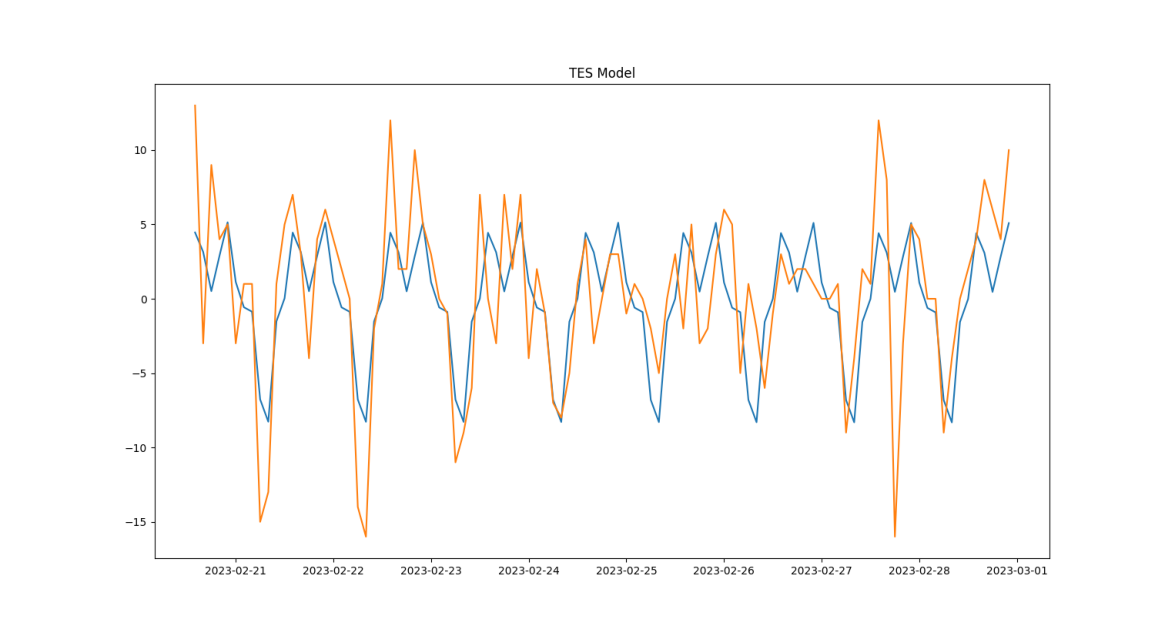

In [50]:
print("MAE Triple Exponential Smoothing:", round(mae(ts_test.Demand, tes_pred), 3))
print("RMSE Triple Exponential Smoothing:", round(rmse(ts_test.Demand, tes_pred), 3), "\n")

img = mpimg.imread('./images/ts_tes.png')
plt.imshow(img)
plt.axis('off')
plt.show()

Both plot and errors, are close to the SARIMA model we found earlier.<br>
In the end, it appered that seasonality indeed existed and played important role in our tests, which is why TES and SARIMA gave the best predictions.<br>
ARIMA(0,0,4)(8,0,1)[12] though, continued to be the best choice of all and it would be the model that we would actually pick to make our predictions in the end.

**ANALYSIS FOR THE TIME SERIES WITH 4 HOUR INTERVALS**

I then recreated the time series using 4 hour intervals.<br>
In this new data, I only tried SARIMA and TES.

**Training data plot**

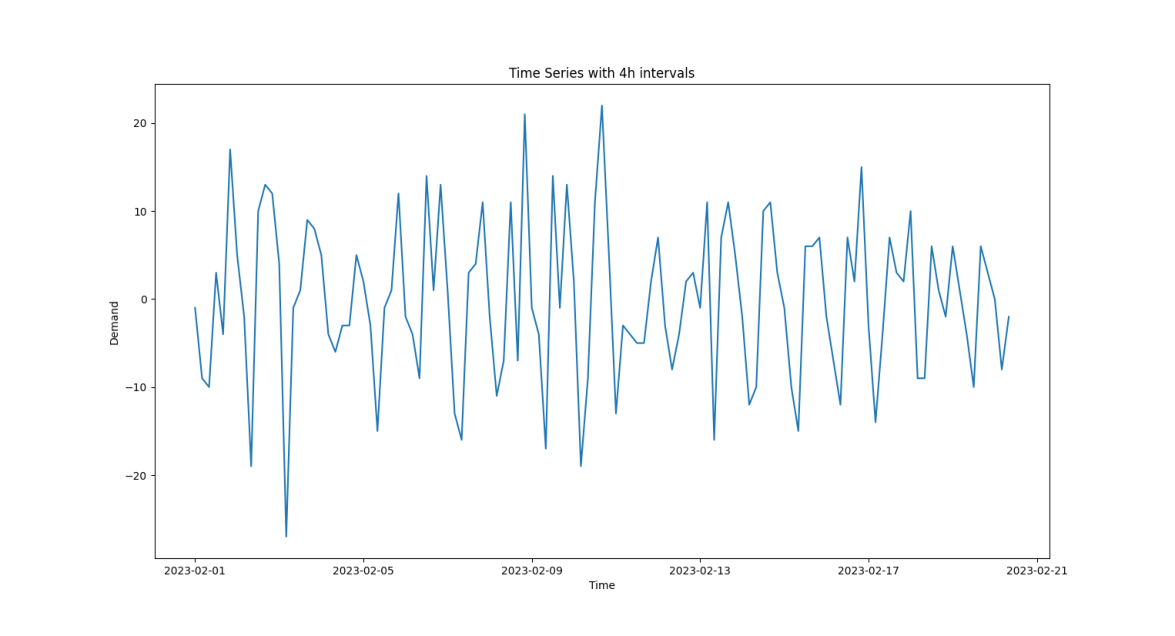

In [51]:
img = mpimg.imread('./images/ts_4h_intervals.png')
plt.imshow(img)
plt.axis('off')
plt.show()

**ACF and PACF plots**

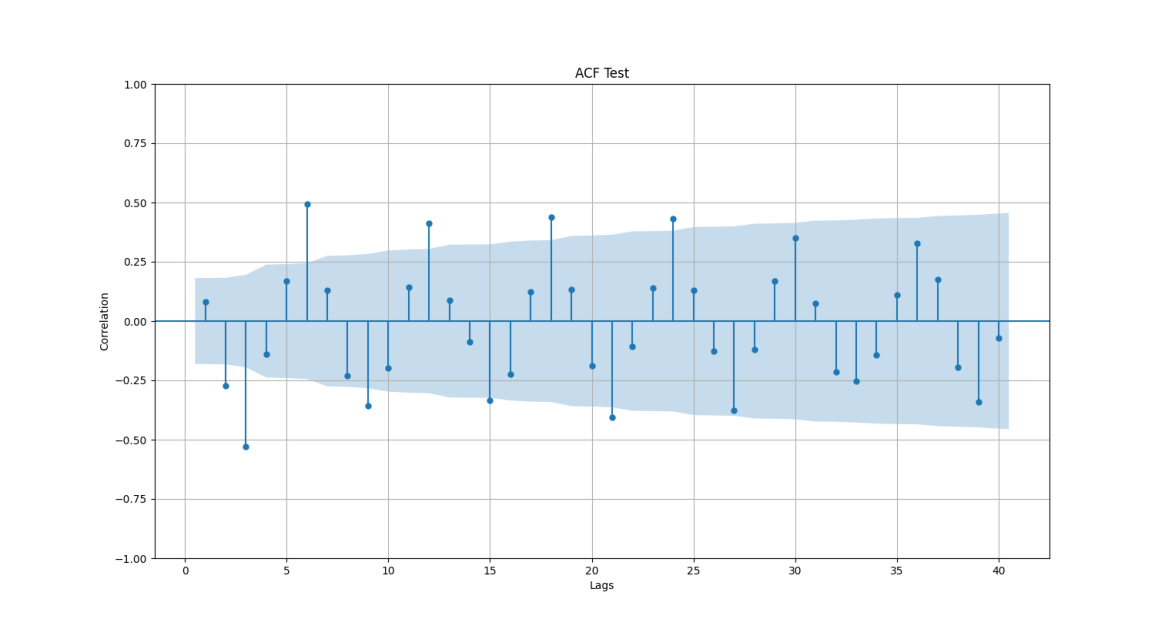

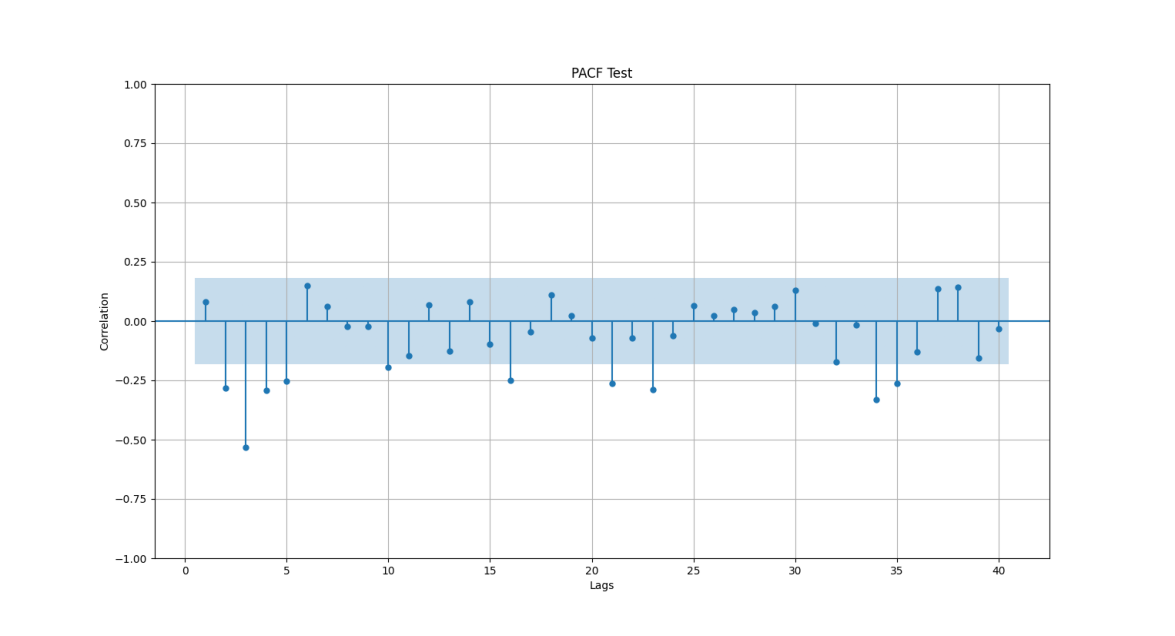

In [52]:
img = mpimg.imread('./images/ts2_acf.png')
plt.imshow(img)
plt.axis('off')
plt.show()

img = mpimg.imread('./images/ts2_pacf.png')
plt.imshow(img)
plt.axis('off')
plt.show()

First, I tried SARIMA, using parameters based on the ACF and PACF plots, but the predictions I got were not good at all.<br>
I then tried as many different parameter values as I could, and I found ARIMA(0,0,0)(2,0,0)[6] to be the best model.

**SARIMA Model test results**

MAE ARIMA(0,0,0)(2,0,0)[6]: 4.179
RMSE ARIMA(0,0,0)(2,0,0)[6]: 5.204 



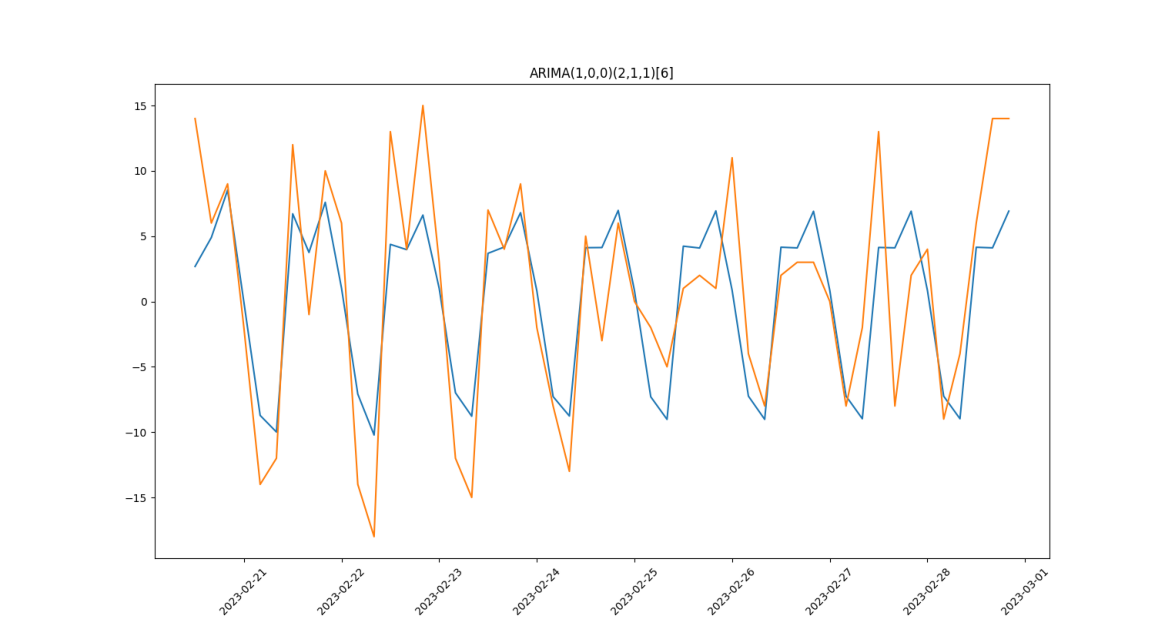

In [53]:
print("MAE ARIMA(0,0,0)(2,0,0)[6]:", round(mae(ts_test2, pred_sar12_i01_ma01), 3))
print("RMSE ARIMA(0,0,0)(2,0,0)[6]:", round(rmse(ts_test2, pred_sar12_i01_ma01), 3), "\n")

img = mpimg.imread('./images/ts2_sarima_best_fit.png')
plt.imshow(img)
plt.axis('off')
plt.show()

I then tried the TES model, which also gave pretty good prediction.

**TES Model test results**

MAE Triple Exponential Smoothing: 4.234
RMSE Triple Exponential Smoothing: 5.237 



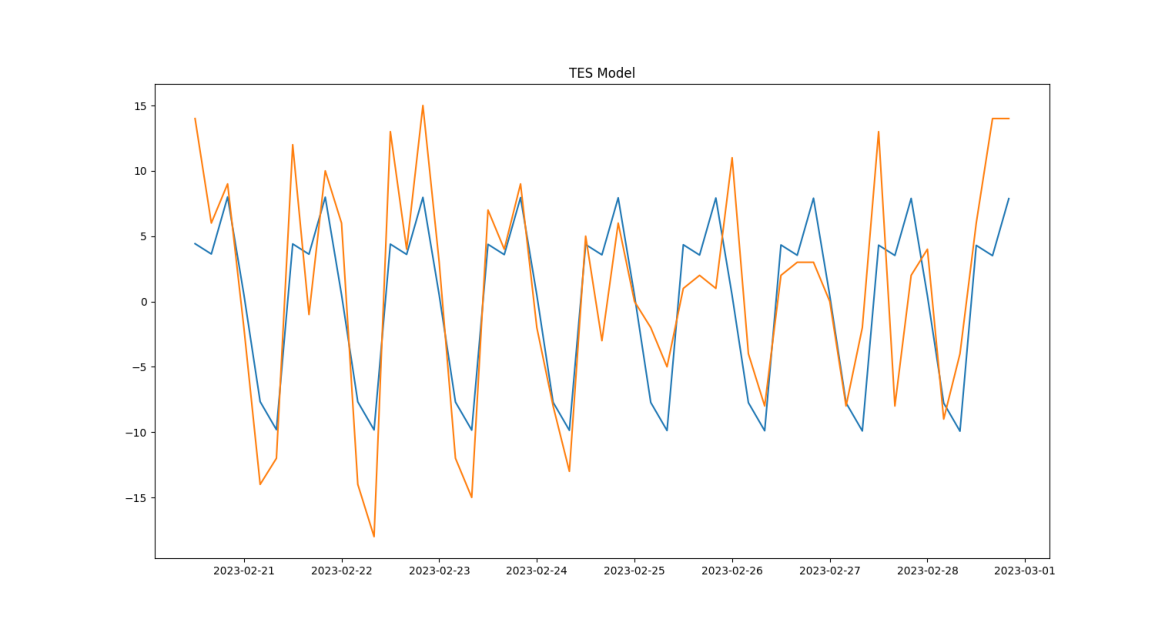

In [54]:
print("MAE Triple Exponential Smoothing:", round(mae(ts_test2, tes2_pred), 3))
print("RMSE Triple Exponential Smoothing:", round(rmse(ts_test2, tes2_pred), 3), "\n")

img = mpimg.imread('./images/ts2_tes.png')
plt.imshow(img)
plt.axis('off')
plt.show()

## **CONCLUSION**

Concluding, I should say that we must always observe the time series and not rely only on the automatic tests that are giving by libraries. If I trusted completely the ADF test, I would never properly use seasonality with SARIMA and TES to achieve better predictions.<br>
<br>
Also, it is good to follow some rules of thumb like deciding model parameters based on the ACF and PACF plots, but we must not stop there. We must perform as many tests we can to improve the prediction, being extra careful not to overfit our data (like it most likely happened in AR(45)).<br>
<br>
At the end, SARIMA and TES offered the best predictions, with SARIMA being a little better. We must of course be careful of the interval's time size when creating our time series, because as we observed above, predicting using SARIMA and TES using 2h intevals gave a lot better predictions than using 4h intervals, as for the later the errors went up by 30%-50%.

**Best prediction for 2h interval time series**

MAE ARIMA(0,0,4)(8,0,1)[12]: 2.984
RMSE ARIMA(0,0,4)(8,0,1)[12]: 4.095 



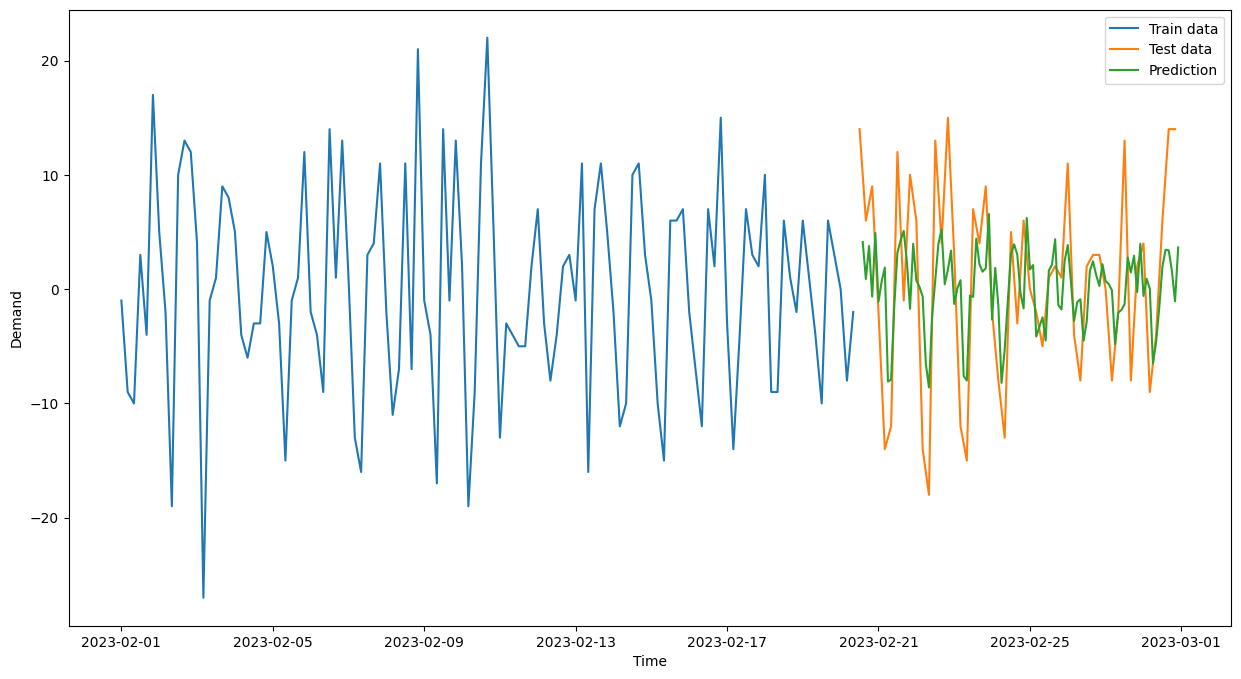

In [58]:
print("MAE ARIMA(0,0,4)(8,0,1)[12]:", round(mae(ts_test.Demand, pred_sar08_ima41), 3))
print("RMSE ARIMA(0,0,4)(8,0,1)[12]:", round(rmse(ts_test.Demand, pred_sar08_ima41), 3), "\n")

plt.plot(ts2, label="Train data")
plt.plot(ts_test2, label="Test data")
plt.plot(pred_sar08_ima41, label="Prediction")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.show()

**Best prediction for 4h interval time series**

MAE ARIMA(0,0,0)(2,0,0)[6]: 4.179
RMSE ARIMA(0,0,0)(2,0,0)[6]: 5.204 



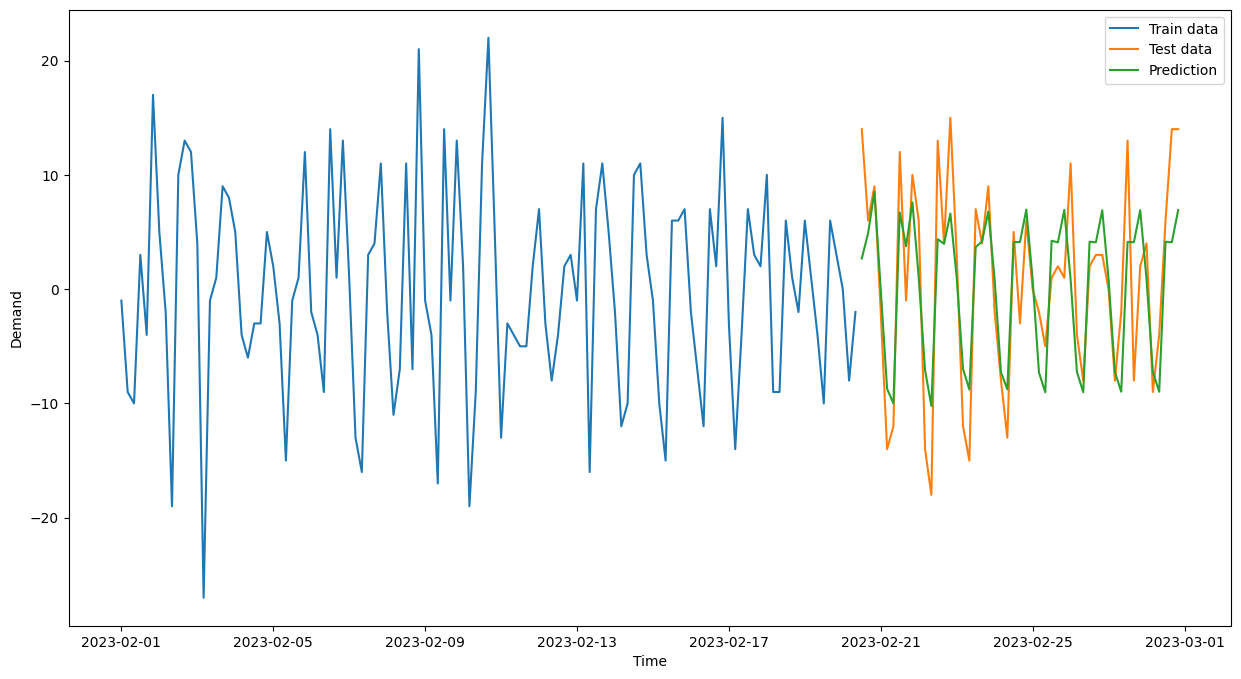

In [59]:
print("MAE ARIMA(0,0,0)(2,0,0)[6]:", round(mae(ts_test2, pred_sar12_i01_ma01), 3))
print("RMSE ARIMA(0,0,0)(2,0,0)[6]:", round(rmse(ts_test2, pred_sar12_i01_ma01), 3), "\n")

plt.plot(ts2, label="Train data")
plt.plot(ts_test2, label="Test data")
plt.plot(pred_sar12_i01_ma01, label="Prediction")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.show()